In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Start

In [2]:
words = open('names.txt', 'r').read().splitlines()
print('len: ', len(words))
print('min len: ', min(len(w) for w in words))
print('max len: ', max(len(w) for w in words))
print(words[:8])

len:  32033
min len:  2
max len:  15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print('voc size: ', vocab_size)
print(itos)

voc size:  27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3 # context length: how many characters we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

num of params:  11897


# Train

      0/ 200000: 28.6816
  10000/ 200000: 2.9745
  20000/ 200000: 1.8441
  30000/ 200000: 2.3877
  40000/ 200000: 2.3740
  50000/ 200000: 2.4421
  60000/ 200000: 2.2276
  70000/ 200000: 2.6593
  80000/ 200000: 2.3501
  90000/ 200000: 2.1634
 100000/ 200000: 2.4779
 110000/ 200000: 2.0594
 120000/ 200000: 2.0402
 130000/ 200000: 2.1701
 140000/ 200000: 1.8375
 150000/ 200000: 2.4765
 160000/ 200000: 2.1218
 170000/ 200000: 2.5047
 180000/ 200000: 2.3550
 190000/ 200000: 1.9117
final minibatch loss:  2.7280590534210205


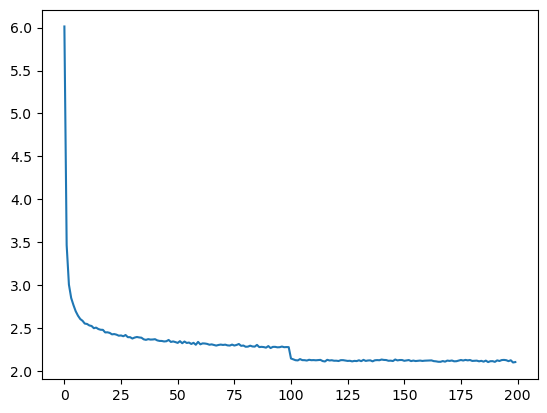

In [6]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

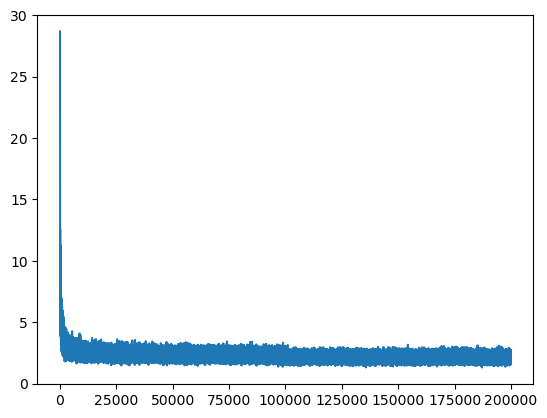

In [7]:
plt.plot(lossi)

In [8]:
# evaluate loss on all dev data
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (B, 100)
logits = h @ W2 + b2 # (B, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1533, grad_fn=<NllLossBackward0>)

## metrics

In [9]:
@torch.no_grad() # disable gradient checking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.113075017929077
val 2.1533381938934326


In [10]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    context= [0] * block_size # init with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

cer.
malomanus.
ilah.
tyhamellissana.
nylla.
kama.
da.
samiyah.
javer.
gotti.
moriella.
kinzoreda.
kaley.
maside.
eniavion.
zatls.
millie.
broah.
ash.
jadra.


# Fix initial loss

In [11]:
# We have loss on 1st iter: 21.09
# at init nn make distro that all missed up, some characters are very confident and missed and others vice versa
# nn very confidently wrong -> high loss
# but if all characters sampled from uniform distribution we expect:

-torch.tensor(1/vocab_size).log()

tensor(3.2958)

In [12]:
# 4-dim example of the issue
# random suggestion:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0,])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [13]:
# 4-dim example of the issue
logits = torch.tensor([0.0, 0.0, 2.0, 0.0,])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0963, 0.0963, 0.7112, 0.0963]), tensor(0.3408))

In [14]:
# 4-dim example of the issue
logits = torch.tensor([0.0, 5.0, 0.0, 0.0,])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [15]:
# 4-dim example of the issue
logits = torch.tensor([-3.0, 10.0, 0.0, 0.0,])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([2.2601e-06, 9.9991e-01, 4.5396e-05, 4.5396e-05]), tensor(10.0001))

In [16]:
# 4-dim example of the issue
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ -1.8145,  -0.6719,  -2.7399, -17.1848]),
 tensor([2.2069e-01, 6.9183e-01, 8.7477e-02, 4.6619e-08]),
 tensor(2.4364))

In [17]:
# we want logits near zero (0) when network is initialized

## basic init

In [18]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

num of params:  11897


## see the issue

In [19]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())
    break 


      0/ 200000: 26.3725


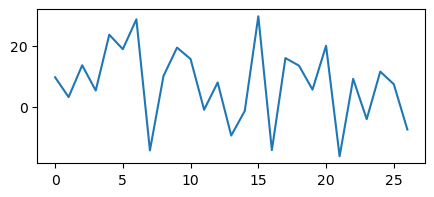

In [20]:
plt.figure(figsize=(5, 2))
plt.plot(logits[0].detach())

In [21]:
# must be much more closer to zero
logits[0], Yb[0]

(tensor([  9.6442,   3.1760,  13.5646,   5.3163,  23.5164,  18.8054,  28.5433,
         -14.2011,  10.0533,  19.3151,  15.5891,  -0.9409,   7.9540,  -9.3594,
          -1.3362,  29.5317, -14.1194,  15.9005,  13.4357,   5.6214,  19.9172,
         -16.1224,   9.1239,  -4.0193,  11.4900,   7.3704,  -7.3971],
        grad_fn=<SelectBackward0>),
 tensor(1))

## Fix init

In [22]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item()) 
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())
    break 

num of params:  11897
      0/ 200000: 3.3082


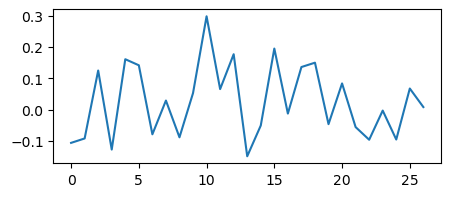

In [23]:
plt.figure(figsize=(5, 2))
plt.plot(logits[0].detach())

In [24]:
logits[0]

tensor([-0.1069, -0.0927,  0.1254, -0.1283,  0.1616,  0.1421, -0.0794,  0.0289,
        -0.0890,  0.0529,  0.2994,  0.0657,  0.1776, -0.1499, -0.0512,  0.1958,
        -0.0129,  0.1365,  0.1505, -0.0468,  0.0839, -0.0562, -0.0968, -0.0032,
        -0.0961,  0.0676,  0.0080], grad_fn=<SelectBackward0>)

## Run with fixed init

In [25]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

num of params:  11897


      0/ 200000: 3.2984
  10000/ 200000: 2.1195
  20000/ 200000: 2.2110
  30000/ 200000: 2.4971
  40000/ 200000: 1.9649
  50000/ 200000: 2.7037
  60000/ 200000: 2.3200
  70000/ 200000: 1.9564
  80000/ 200000: 1.9606
  90000/ 200000: 2.0644
 100000/ 200000: 2.4917
 110000/ 200000: 2.0343
 120000/ 200000: 2.4211
 130000/ 200000: 1.9869
 140000/ 200000: 2.2061
 150000/ 200000: 2.0121
 160000/ 200000: 1.8229
 170000/ 200000: 1.8844
 180000/ 200000: 1.9865
 190000/ 200000: 2.1900
final minibatch loss:  1.7055628299713135


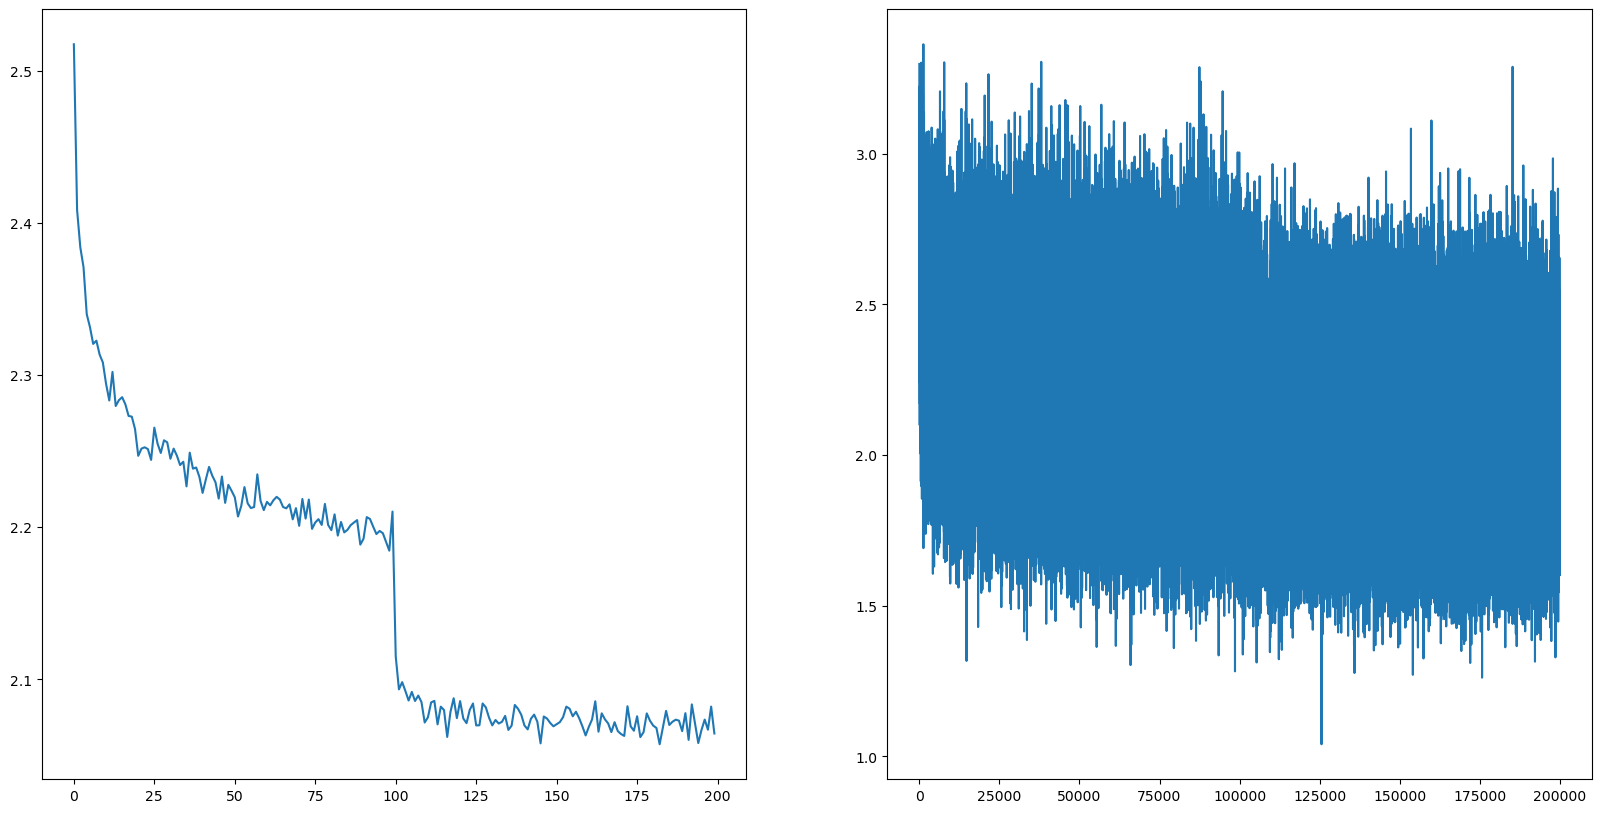

In [26]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

## metics

In [27]:
split_loss('train')
split_loss('val')

train 2.0705296993255615
val 2.135953664779663


# Fixing saturated tanh

In [28]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item()) 
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())
    break 

num of params:  11897
      0/ 200000: 3.3067


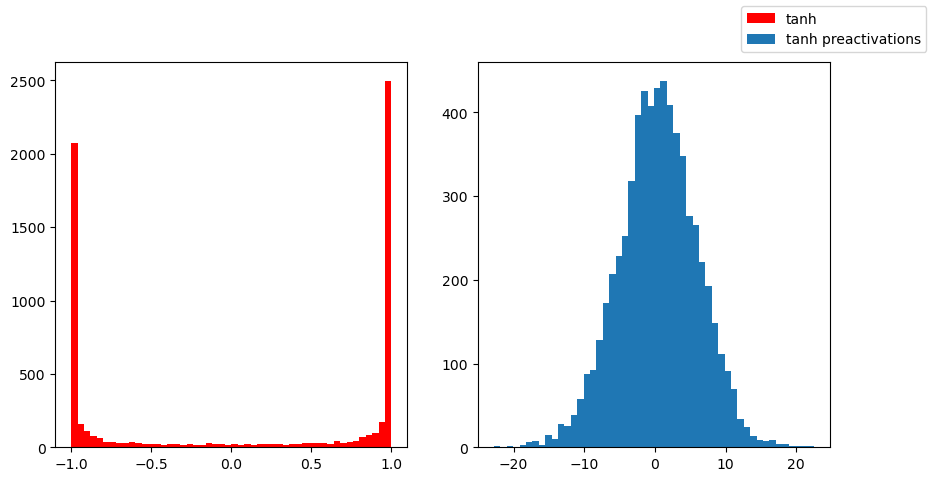

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(h.view(-1).tolist(), 50, label="tanh", color="r");
ax[1].hist(hpreact.view(-1).tolist(), 50, label='tanh preactivations');
fig.legend();

In [30]:
# most of values get values -1 and 1 -> tanh is very active
# so very small update after tanh -> grads ~~ zero !! killing gradient
# we are at the tail at the flat region
# # if lots of values are 1 and -1 -> gradents are destroyed after that layer

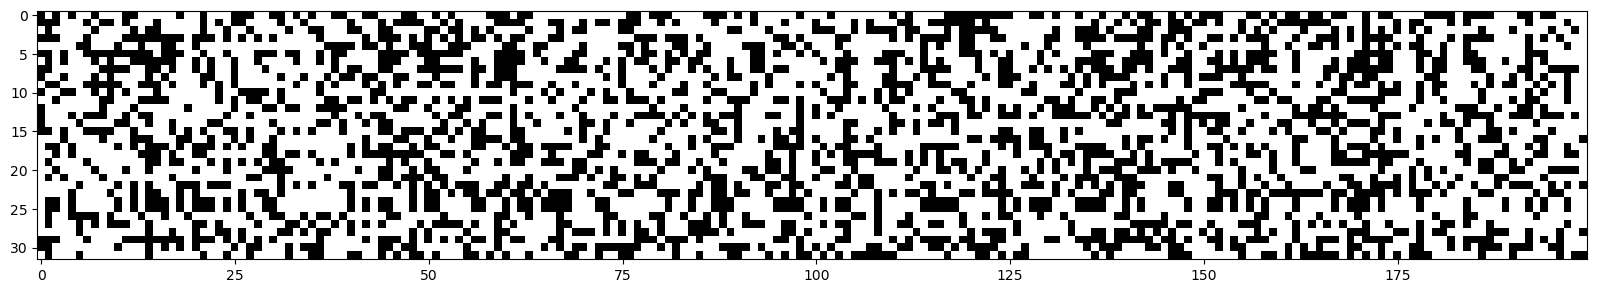

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");
# white = true
# black = false
# died neuron if one column = zero (white) -> never learn
# never matter what input we passed through it it always 1 and -1 

In [32]:
# Problem in W1

## Fix issue

In [33]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item()) 
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())
    break 

num of params:  11897
      0/ 200000: 3.2796


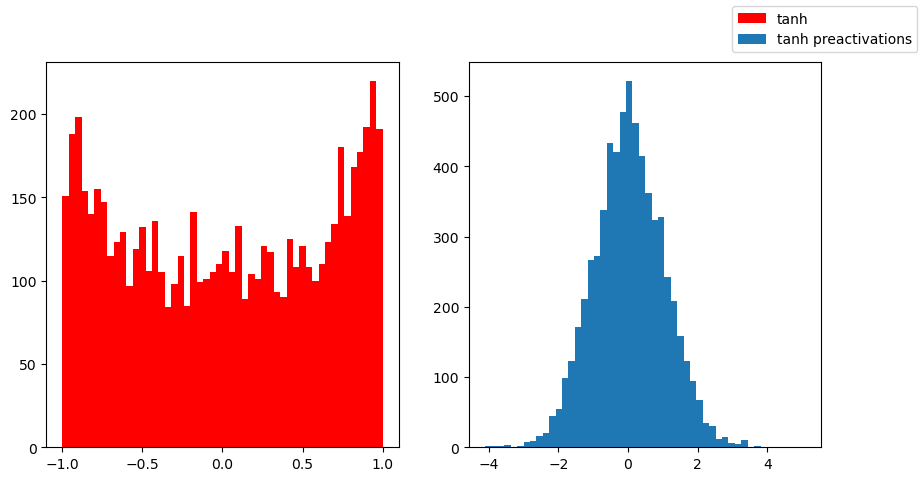

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(h.view(-1).tolist(), 50, label="tanh", color="r");
ax[1].hist(hpreact.view(-1).tolist(), 50, label='tanh preactivations');
fig.legend();

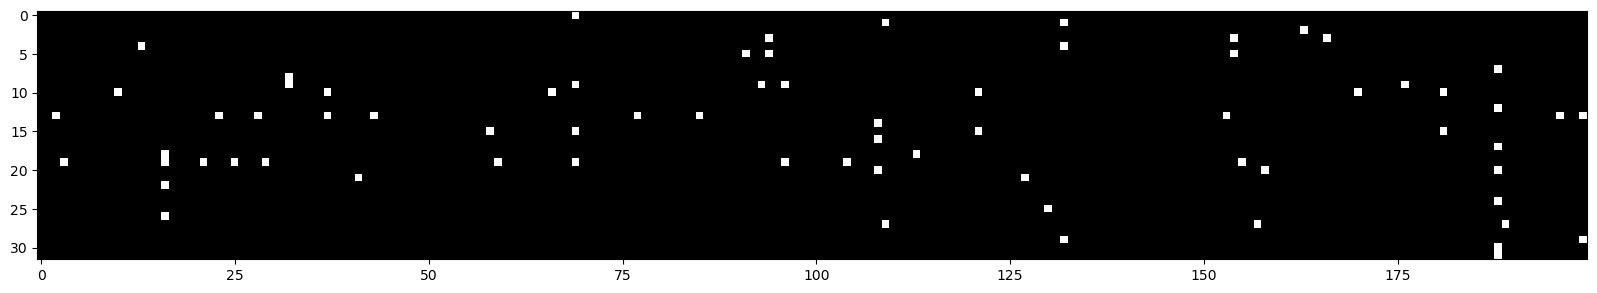

In [35]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");
# white = true
# black = false

## Run with fixed tanh saturated at init

In [36]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

num of params:  11897


      0/ 200000: 3.2942
  10000/ 200000: 2.0719
  20000/ 200000: 2.4225
  30000/ 200000: 2.0566
  40000/ 200000: 2.5488
  50000/ 200000: 1.9338
  60000/ 200000: 2.0495
  70000/ 200000: 2.1783
  80000/ 200000: 1.8200
  90000/ 200000: 2.1212
 100000/ 200000: 2.2625
 110000/ 200000: 2.1641
 120000/ 200000: 1.9101
 130000/ 200000: 1.9093
 140000/ 200000: 2.3028
 150000/ 200000: 2.1182
 160000/ 200000: 2.2689
 170000/ 200000: 1.9166
 180000/ 200000: 2.3242
 190000/ 200000: 2.2602
final minibatch loss:  2.108268976211548


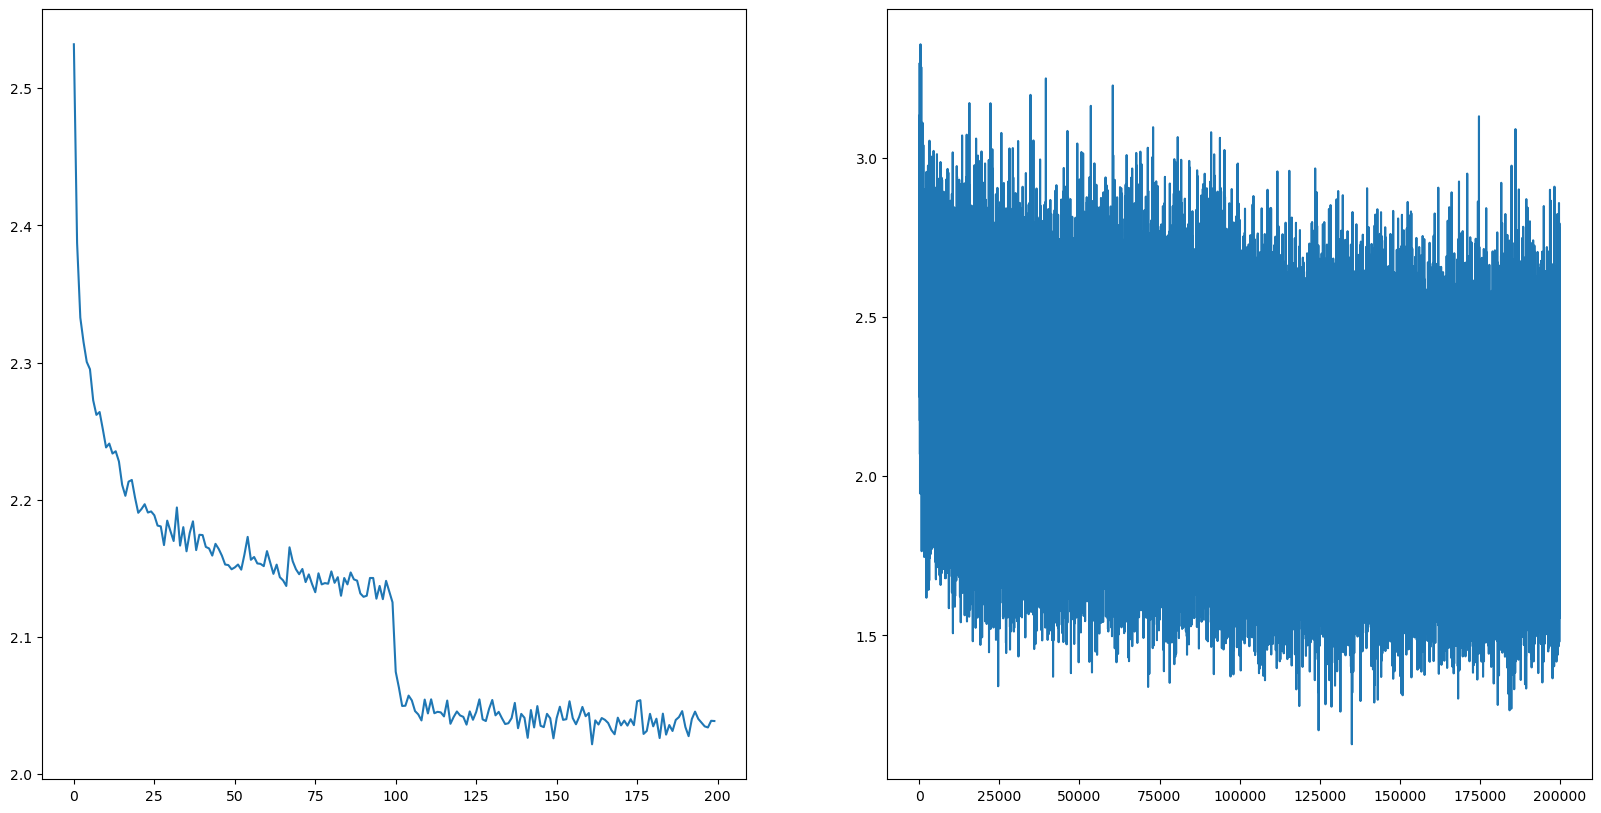

In [37]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

## metics

In [38]:
split_loss('train')
split_loss('val')

train 2.035395383834839
val 2.1030540466308594


# Kaiming init

In [105]:
%matplotlib inline

tensor(-0.0047) tensor(1.0055)
tensor(-0.0030) tensor(3.1953)


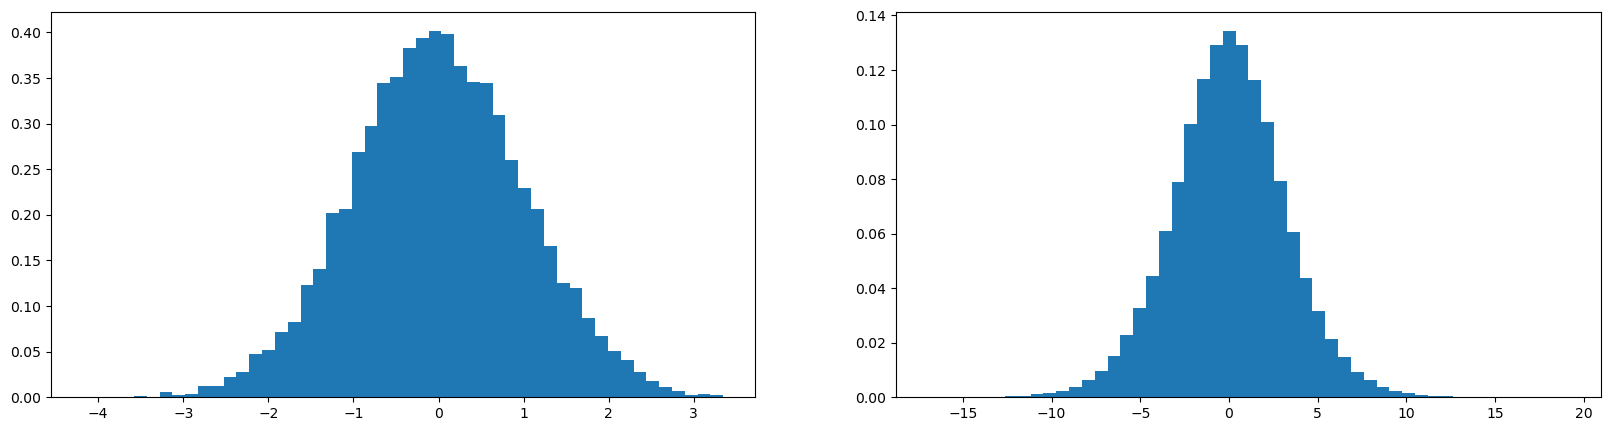

In [39]:
# how we scale that distribution to reamin it gaussion with std = 1 ??
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0034) tensor(0.9906)
tensor(0.0086) tensor(15.8997)


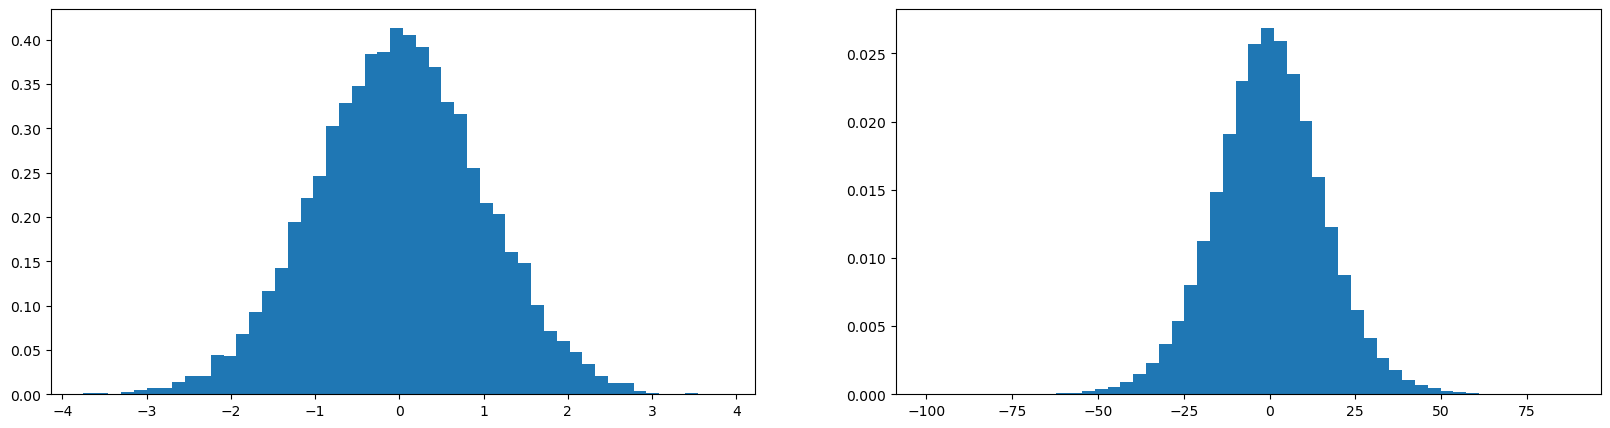

In [40]:
# how we scale that distribution to reamin it gaussion with std = 1 ??
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0120) tensor(1.0101)
tensor(-0.0027) tensor(1.0085)


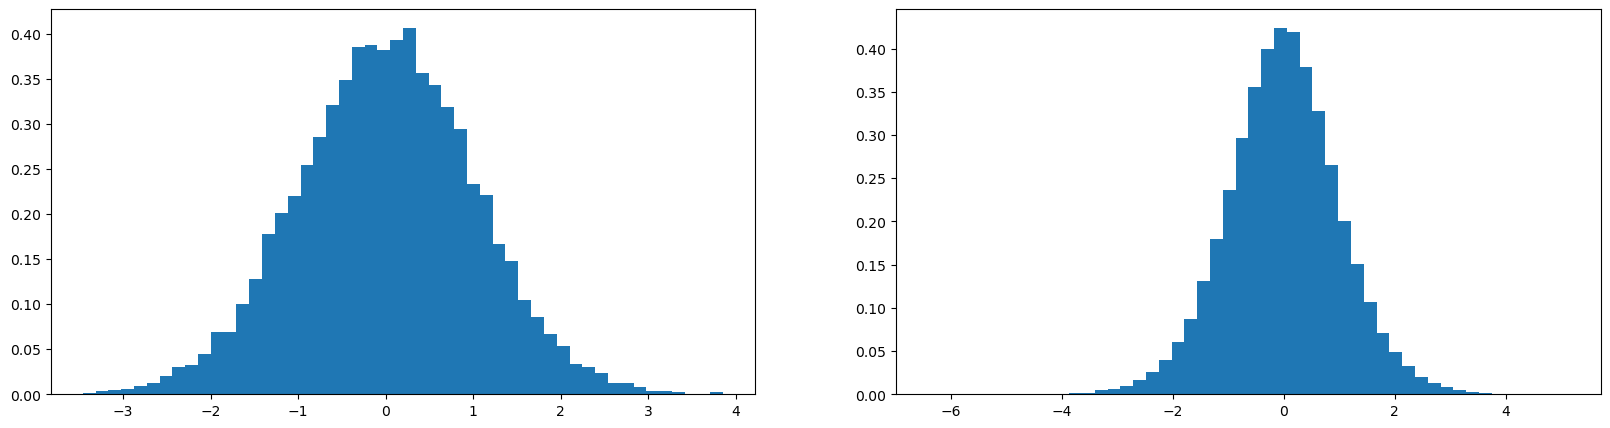

In [215]:
# how we scale that distribution to reamin it gaussion with std = 1 ??
# kaiming init ( gain / f_in ** 0.5)
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0017) tensor(0.9918)
tensor(0.5469) tensor(0.8324)


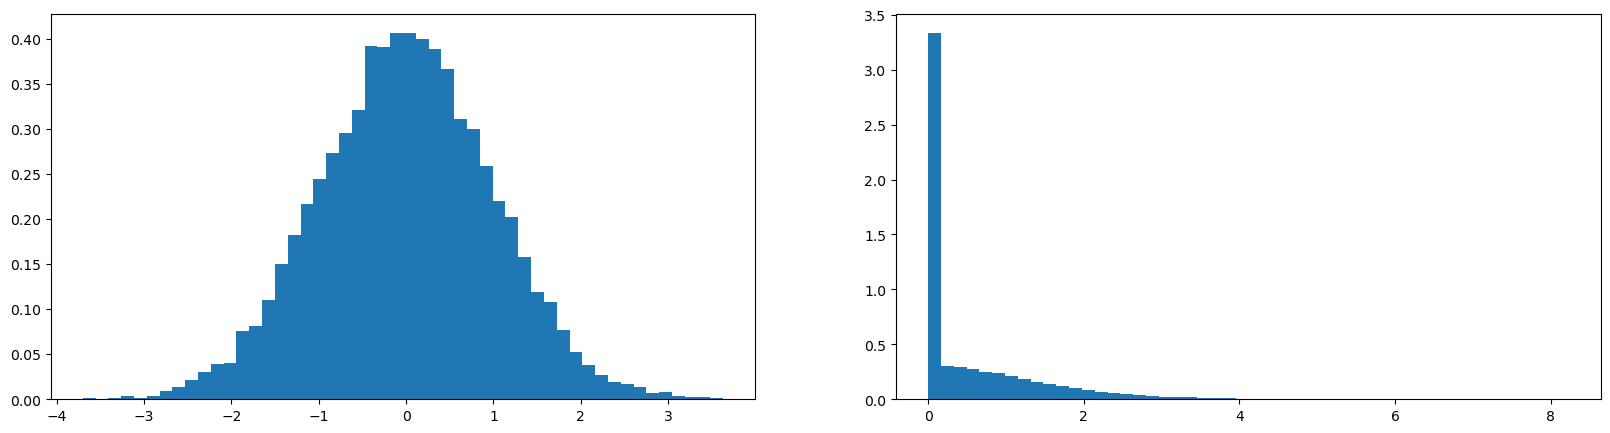

In [222]:
# how we scale that distribution to reamin it gaussion with std = 1 ??
# kaiming init ( gain / f_in ** 0.5)
# relu example
relu = torch.nn.ReLU()
x = torch.randn(1000, 10)
w = torch.randn(10, 200)  * (2/10) ** 0.5
y = relu(x @ w)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [223]:
# if M[x] = 0 -> Var[x] = M[x**2]
print(y.mean())
print(y.pow(2).mean().sqrt())

tensor(0.5469)
tensor(0.9960)


## setting up init by kaiming

In [234]:
# init for kaiming
(5/3)/(n_embd*block_size)** 0.5

0.3042903097250923

In [235]:
n_embd = 10
n_hidden = 200
# 5/3 - gain for tanh
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

num of params:  11897


In [236]:
print('multiplaying W1 by: ', round((5/3)/((n_embd*block_size)**0.5), 4))

multiplaying W1 by:  0.3043


      0/ 200000: 3.2868
  10000/ 200000: 2.1323
  20000/ 200000: 2.3816
  30000/ 200000: 1.9480
  40000/ 200000: 2.5117
  50000/ 200000: 1.9814
  60000/ 200000: 1.7142
  70000/ 200000: 2.3908
  80000/ 200000: 1.9320
  90000/ 200000: 1.8117
 100000/ 200000: 2.4562
 110000/ 200000: 2.0451
 120000/ 200000: 2.0525
 130000/ 200000: 2.4543
 140000/ 200000: 2.0423
 150000/ 200000: 2.0133
 160000/ 200000: 2.0563
 170000/ 200000: 2.0616
 180000/ 200000: 1.9758
 190000/ 200000: 2.0368
final minibatch loss:  2.0137484073638916


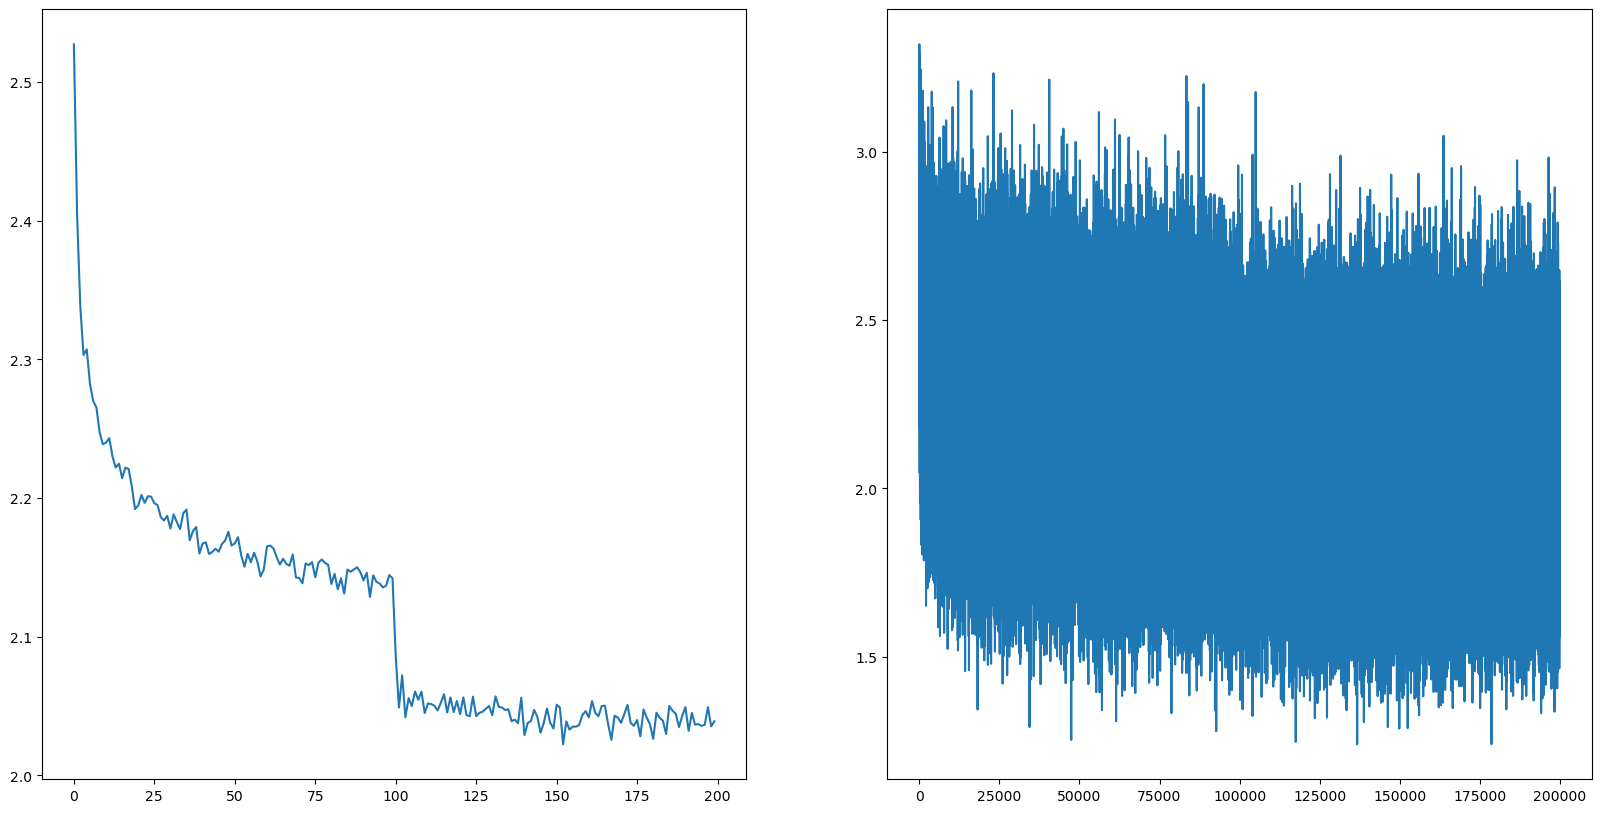

In [237]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

## metics

In [238]:
split_loss('train')
split_loss('val')

train 2.0388410091400146
val 2.1083102226257324


# Batch normalization

In [251]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
# 5/3 - gain for tanh
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

num of params:  12297


In [252]:
print('multiplaying W1 by: ', round((5/3)/((n_embd*block_size)**0.5), 4))

multiplaying W1 by:  0.3043


## Batch norm implementation

In [253]:
# You have hidden states and want them to be guassian
# just take them and make it gaussian!

In [254]:
print(hpreact.shape)

# do mean over all elements in the batch for each neuron
print(hpreact.mean(0, keepdim=True).shape)
print(hpreact.std(0, keepdim=True).shape)
# then make it gaussian with std 1
# (x - mean) / std

torch.Size([32, 200])
torch.Size([1, 200])
torch.Size([1, 200])


In [257]:
# logit not function of one example x of its input
# its also a function of all other examples  that are in sample batch which choosen randomly
# and hidden state activation will be change depending on all other examples in batch 
# and h will change  and its going to jitter for h and for logits

# like regularizer
# x - input, depending on other examples they jittered it (its add some info about all other examples
# and gives some entropy - like data augmentation, and make its harder to overfit neural net
# to overfit that specific example)

# no one like this affect that out random examples become connected mathimaticaly


      0/ 200000: 3.3049
  10000/ 200000: 2.0011
  20000/ 200000: 2.0771
  30000/ 200000: 2.2129
  40000/ 200000: 1.9422
  50000/ 200000: 2.0715
  60000/ 200000: 2.3171
  70000/ 200000: 1.9770
  80000/ 200000: 2.6117
  90000/ 200000: 2.1552
 100000/ 200000: 2.2388
 110000/ 200000: 1.9307
 120000/ 200000: 2.6997
 130000/ 200000: 2.3955
 140000/ 200000: 1.9827
 150000/ 200000: 1.9445
 160000/ 200000: 2.1092
 170000/ 200000: 2.1135
 180000/ 200000: 1.8912
 190000/ 200000: 2.4003
final minibatch loss:  2.07767653465271


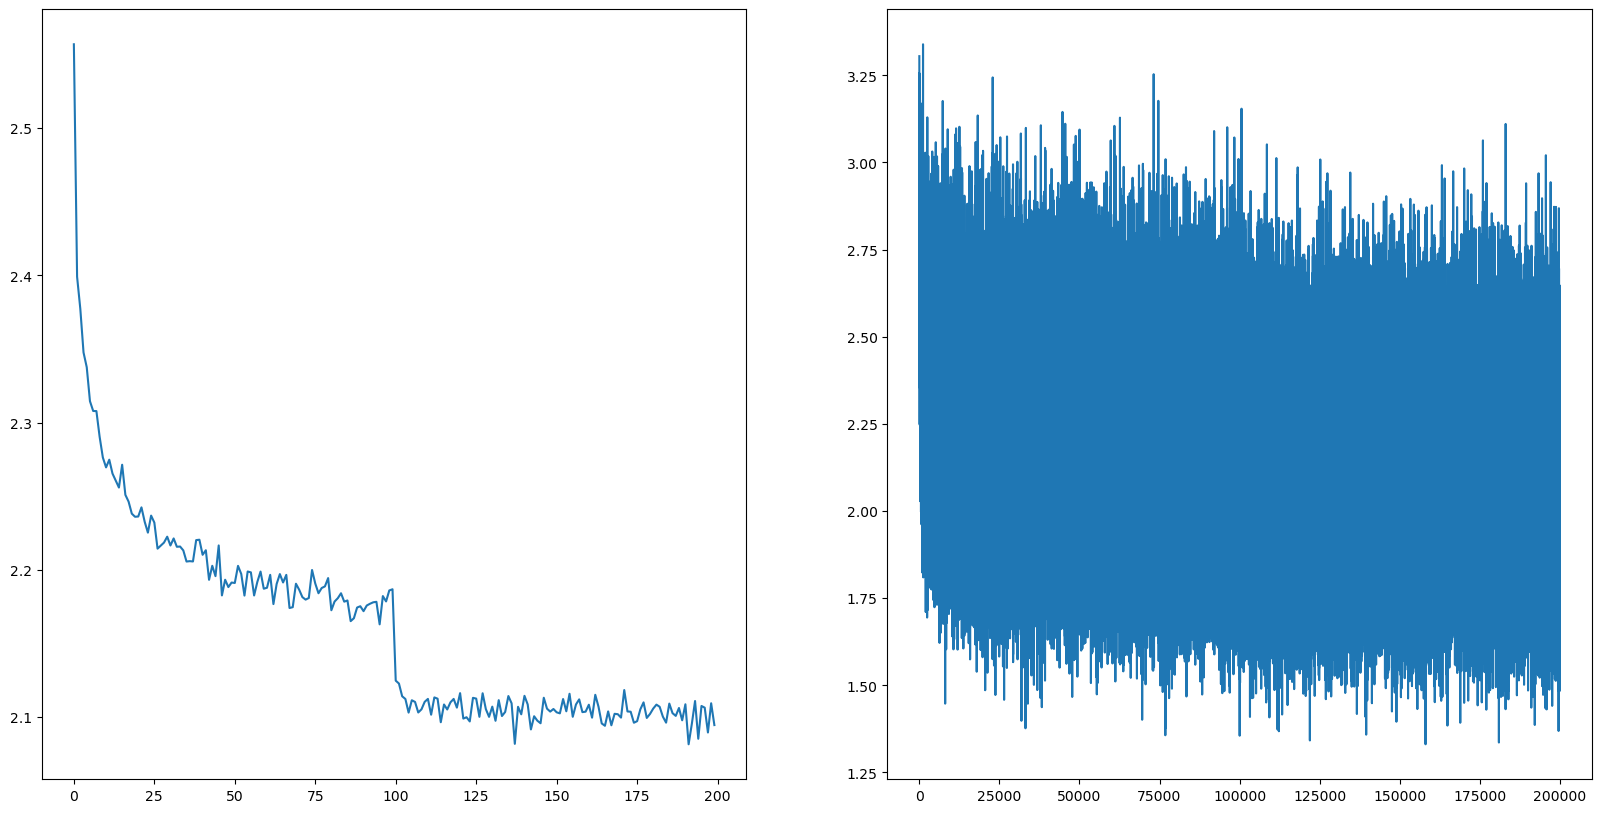

In [255]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

## metics

In [256]:
@torch.no_grad() # disable gradient checking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068161725997925
val 2.108480930328369


## Eval on batch norm

In [259]:
# issue we got batches and now want to make prediction over one single element

# celibrate the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire dataset
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [260]:
@torch.no_grad() # disable gradient checking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    
    # use learned mean and std
    hpreact = (hpreact - bnmean) / bnstd
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068161725997925
val 2.1084673404693604


In [ ]:
# no one want measure mean and std each time
# so we can use running mean and running variance during training

In [263]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
# 5/3 - gain for tanh
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# running mean and std
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

num of params:  12297


## Add running mean and running std

      0/ 200000: 3.3014
  10000/ 200000: 2.6745
  20000/ 200000: 2.8171
  30000/ 200000: 2.0616
  40000/ 200000: 2.0431
  50000/ 200000: 2.2864
  60000/ 200000: 2.3248
  70000/ 200000: 1.9566
  80000/ 200000: 2.2731
  90000/ 200000: 2.0281
 100000/ 200000: 2.3526
 110000/ 200000: 1.8163
 120000/ 200000: 2.3066
 130000/ 200000: 2.1549
 140000/ 200000: 2.2485
 150000/ 200000: 2.1401
 160000/ 200000: 2.1329
 170000/ 200000: 2.1475
 180000/ 200000: 1.7644
 190000/ 200000: 2.4660
final minibatch loss:  2.0894811153411865


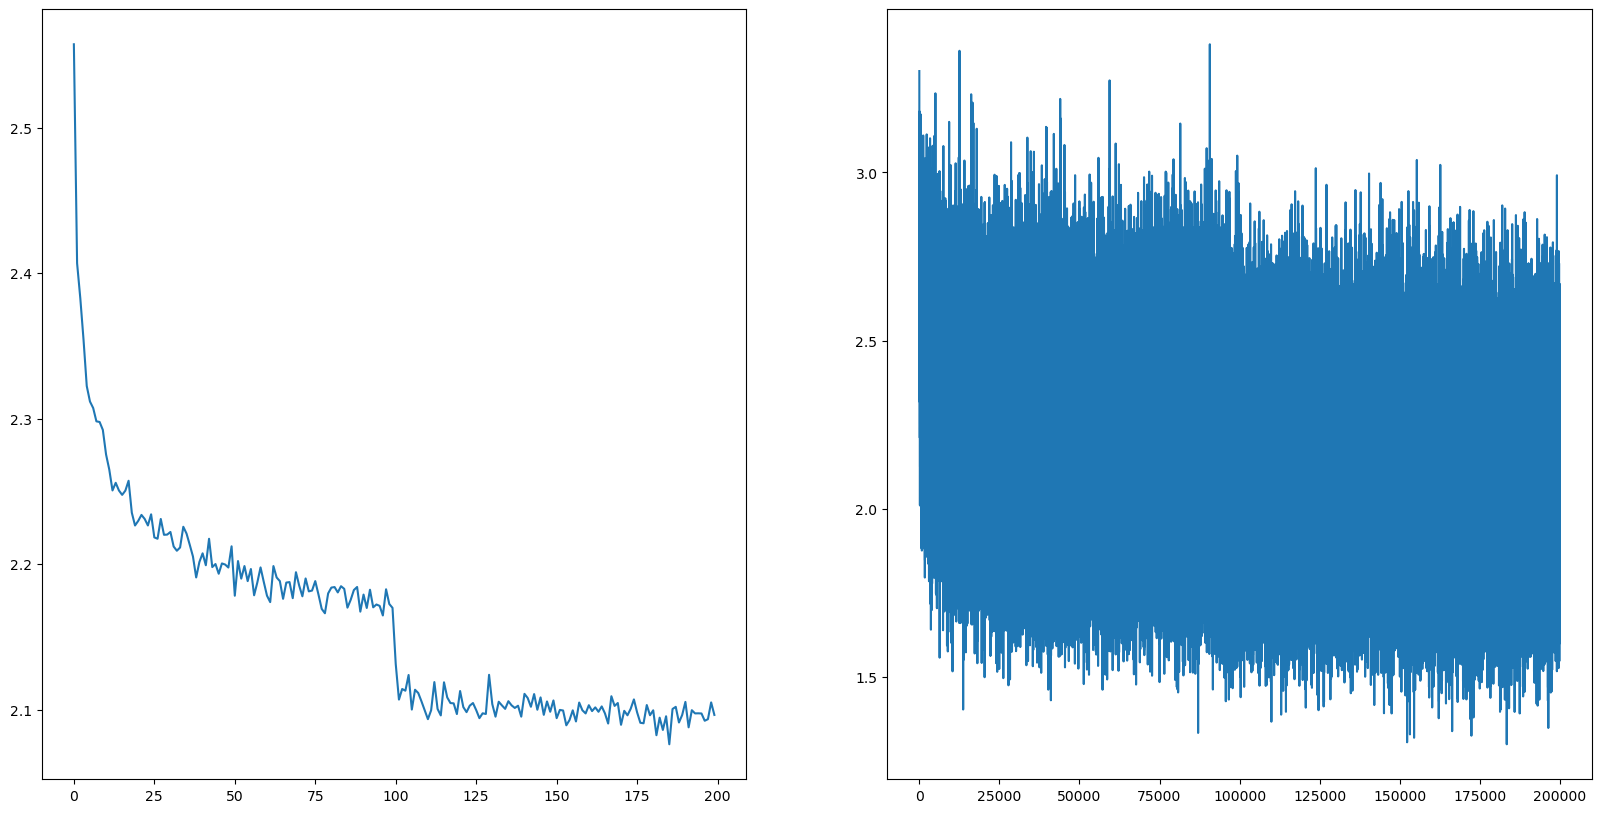

In [264]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = (hpreact - bnmeani) / bnstdi
    
    # update runnig mean and std on training
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

In [265]:
@torch.no_grad() # disable gradient checking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    
    # use learned mean and std from all dataset
    hpreact = (hpreact - bnmean_running) / bnstd_running
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066117286682129
val 2.1101016998291016


In [267]:
# compare bnmean, bnbias with running mean and running std

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire dataset
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

print(bnmean[0, 0], bnmean_running[0, 0])
print(bnstd[0, 0], bnstd_running[0, 0])

tensor(-2.2422) tensor(-2.2579)
tensor(2.1705) tensor(2.1541)


In [269]:
print((bnmean / bnmean_running).mean())
print((bnstd / bnstd_running).mean())
# see that they are very close

tensor(0.9930)
tensor(1.0097)


## notion

<b> We dont need bias any more </b>

```python
hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
....
hpreact = hpreact * bngain + bnbias
```

We will learn other bias and it will be self subtracted

In [275]:
# bias not impact on output so gradient will be zero
b1.grad[:50]

tensor([-9.3132e-10,  9.3132e-10,  1.8626e-09,  9.3132e-10, -2.0955e-09,
        -1.8626e-09,  0.0000e+00,  9.3132e-10,  2.7940e-09,  1.9209e-09,
         4.6566e-10, -1.3970e-09, -4.6566e-10,  0.0000e+00, -9.3132e-10,
         0.0000e+00, -2.3283e-09, -1.8626e-09,  1.3970e-09,  1.3970e-09,
         0.0000e+00, -9.6043e-10, -4.6566e-10,  0.0000e+00, -4.6566e-10,
        -1.3970e-09, -1.3970e-09,  4.6566e-10,  4.6566e-10, -9.3132e-10,
         9.3132e-10,  1.1642e-10, -2.3283e-10, -1.3970e-09, -4.6566e-09,
         1.1642e-10,  1.3970e-09, -1.1642e-09, -2.3283e-10,  0.0000e+00,
        -1.8626e-09,  6.9849e-10, -5.8208e-10,  2.1828e-11, -9.3132e-10,
        -4.6566e-10,  1.9791e-09,  4.6566e-09,  8.1491e-10,  9.3132e-10])

## final batch norm version

In [282]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [284]:
if 3 < 5 < 9:
    print(5)

5


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707
final minibatch loss:  2.0136187076568604


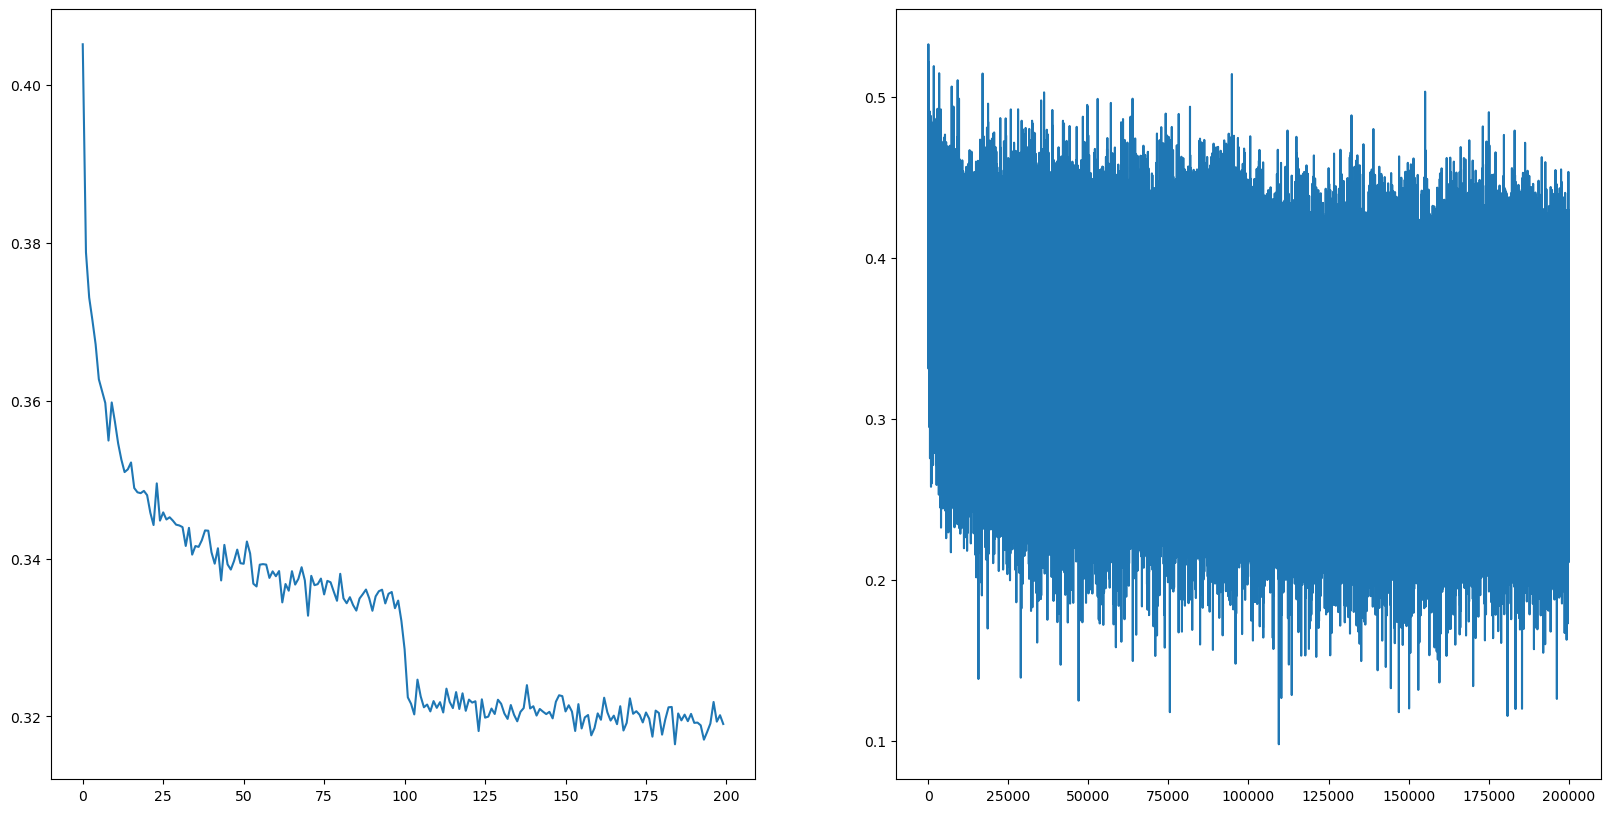

In [283]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

In [ ]:
@torch.no_grad() # disable gradient checking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    
    # use learned mean and std from all dataset
    hpreact = (hpreact - bnmean_running) / bnstd_running
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [248]:
split_loss('train')
split_loss('val')

train 3.308176279067993
val 3.308014154434204


## Check how running mean and std changes

In [52]:
run_mean, run_std = [], []

num of params:  12297
      0/  40000: 3.3181
  10000/  40000: 2.1081
  20000/  40000: 2.4138
  30000/  40000: 2.4290
final minibatch loss:  1.8541309833526611


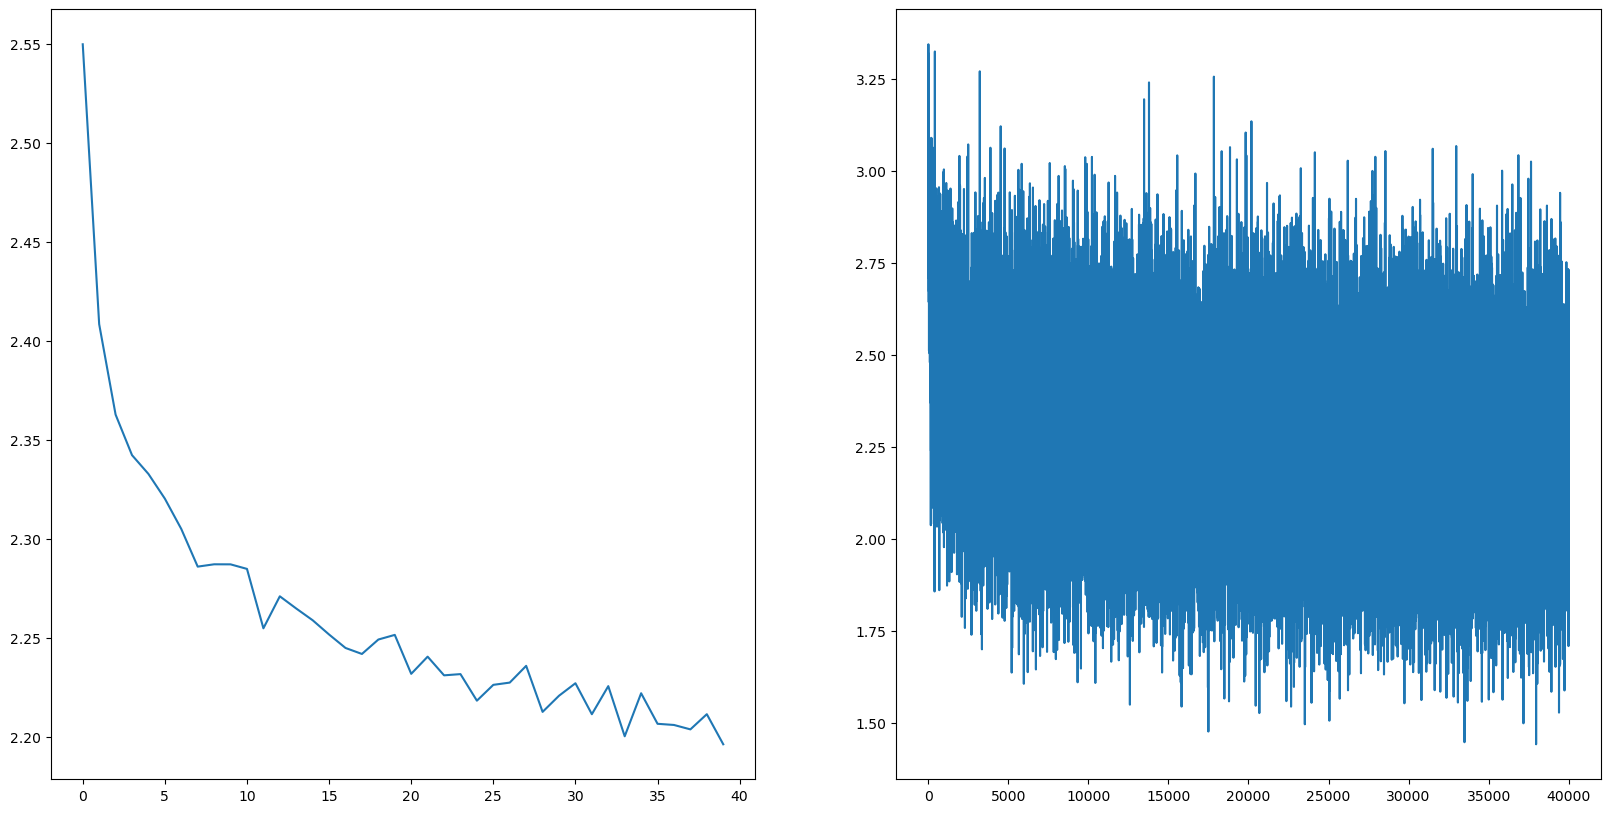

In [53]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
# 5/3 - gain for tanh
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# running mean and std
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print('num of params: ', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True
    
max_steps = 40000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    
    # BATCH NORM
    
    # we have neuron and its fiting rate will be exactly unit gaussian
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = (hpreact - bnmeani) / bnstdi
    
    # update runnig mean and std on training
    with torch.no_grad():
        bnmean_running = 0.9 * bnmean_running + 0.1 * bnmeani
        bnstd_running = 0.9 * bnstd_running + 0.1 * bnstdi
        run_mean.append(bnmean_running)
        run_std.append(bnstd_running)
    
    # we want that distibution to move around
    hpreact = hpreact * bngain + bnbias
    
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    
print('final minibatch loss: ', loss.item())
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(torch.tensor(lossi).view(-1, 1000).mean(1));
ax[1].plot(lossi)

In [33]:
run_std[0][0, 3]

tensor(0.0016)

### Momentum 0.001

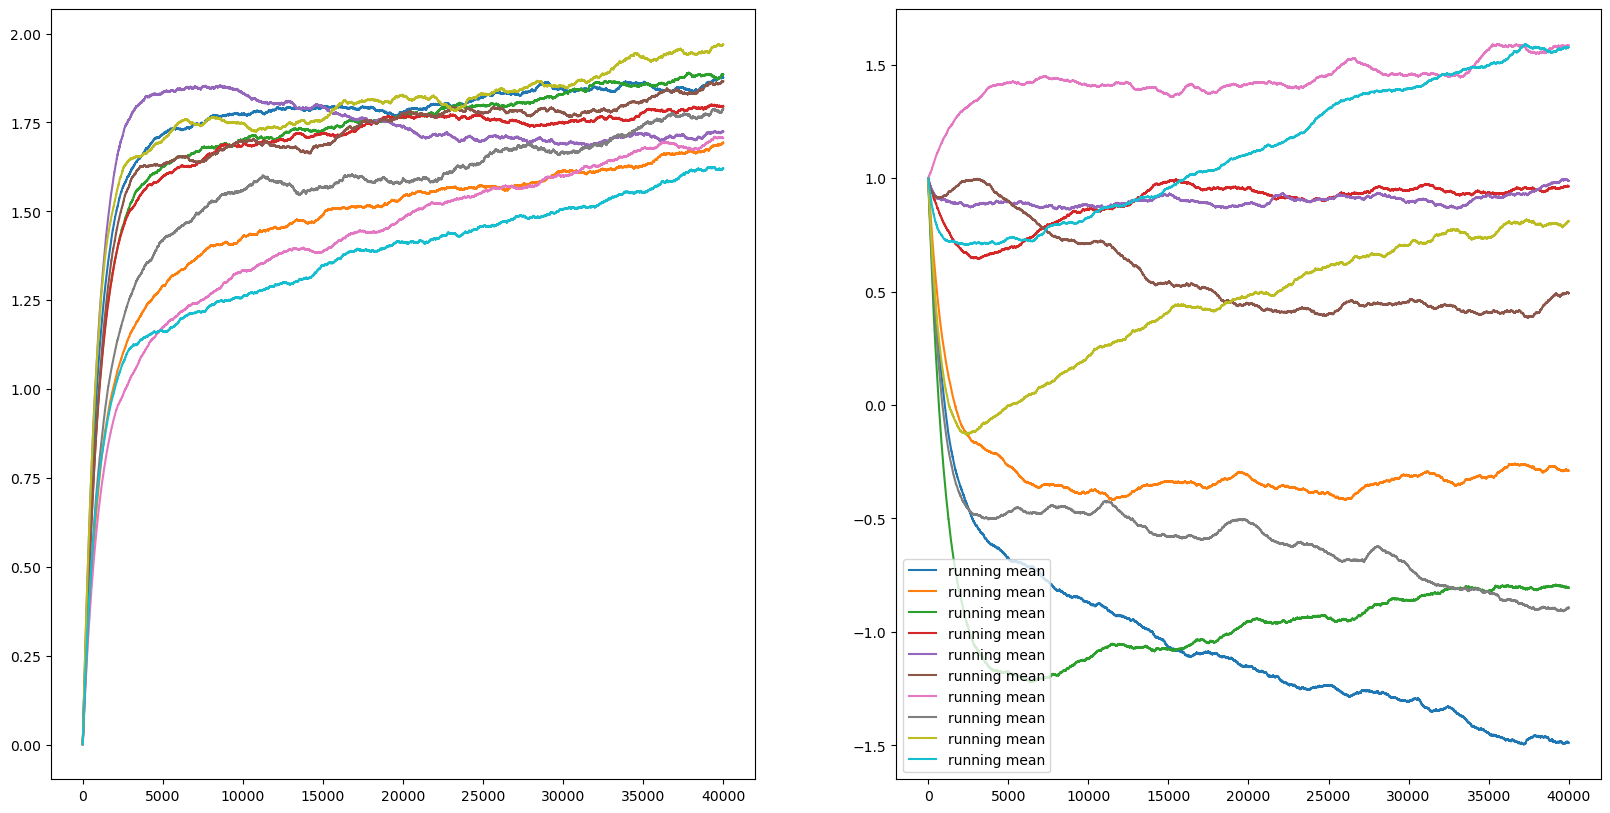

In [51]:
run_stdi = [r_std[0, :10].tolist() for r_std in run_std]
run_meani = [r_mean[0, :10].tolist() for r_mean in run_mean]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(run_stdi, label='running stds');
ax[1].plot(run_meani, label='running mean')
plt.legend();

### Momentum 0.1

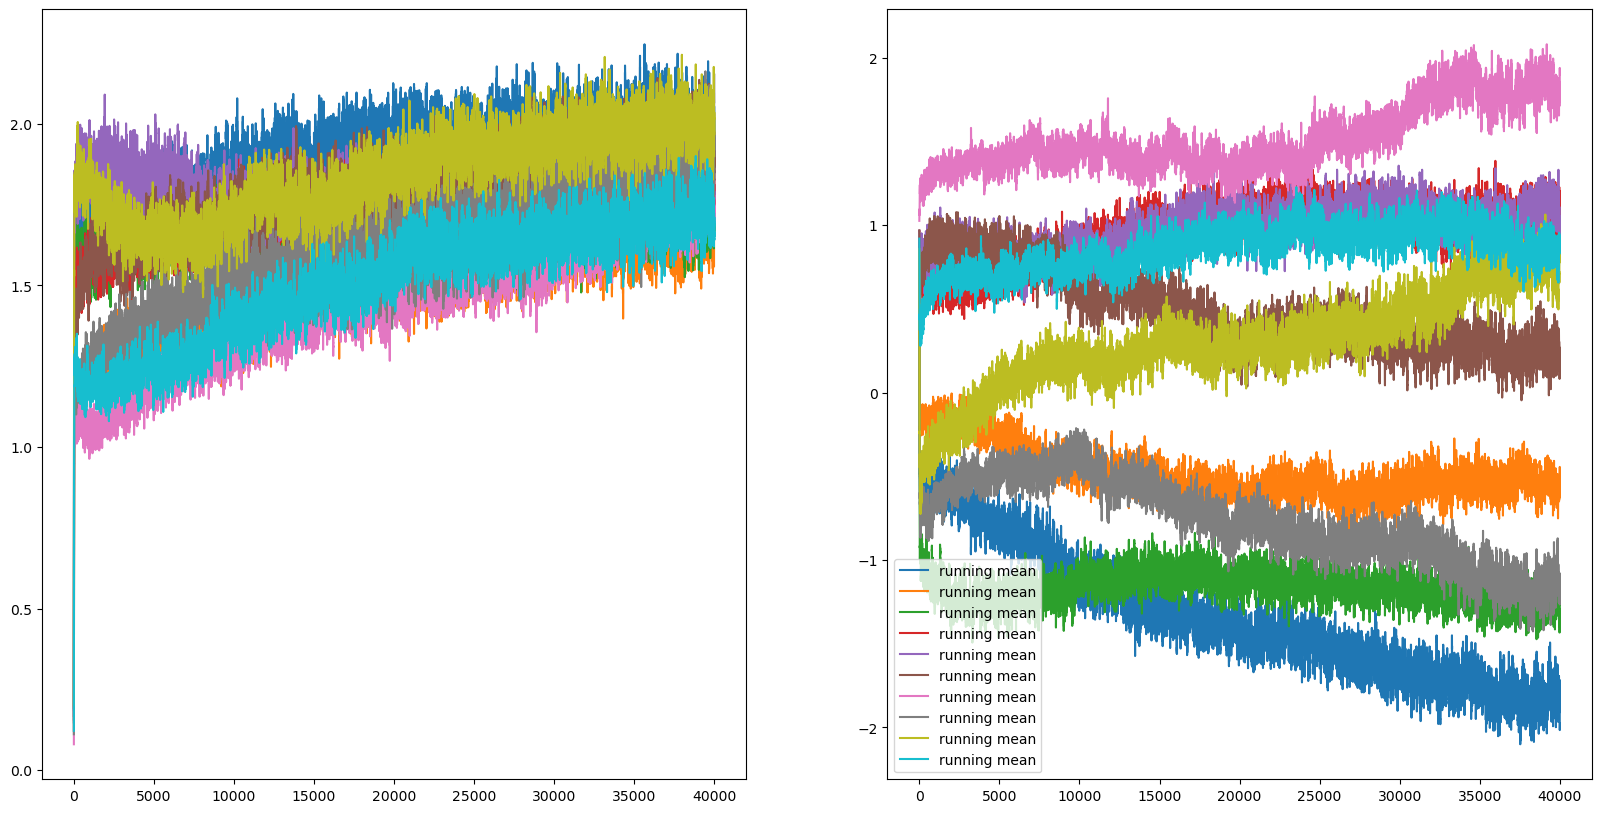

In [54]:
run_stdi = [r_std[0, :10].tolist() for r_std in run_std]
run_meani = [r_mean[0, :10].tolist() for r_mean in run_mean]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(run_stdi, label='running stds');
ax[1].plot(run_meani, label='running mean')
plt.legend();

<b> Larger batch size -> larger momentum </b>

# PyTorch-ifying code

In [72]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = xhat * self.gamma + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)


layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].weight *= 0.1
    
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 # 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

46497


In [73]:
max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concat vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain grad
        
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    break # AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2960


# Vizualize layers histograms

## with gain 5/3 for linear:

layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.03%
layer 3 (      Tanh): mean +0.00, std 0.68, saturated: 8.38%
layer 5 (      Tanh): mean -0.00, std 0.67, saturated: 7.37%
layer 7 (      Tanh): mean -0.03, std 0.66, saturated: 5.66%
layer 9 (      Tanh): mean -0.03, std 0.66, saturated: 6.66%


Text(0.5, 1.0, 'activation distribution')

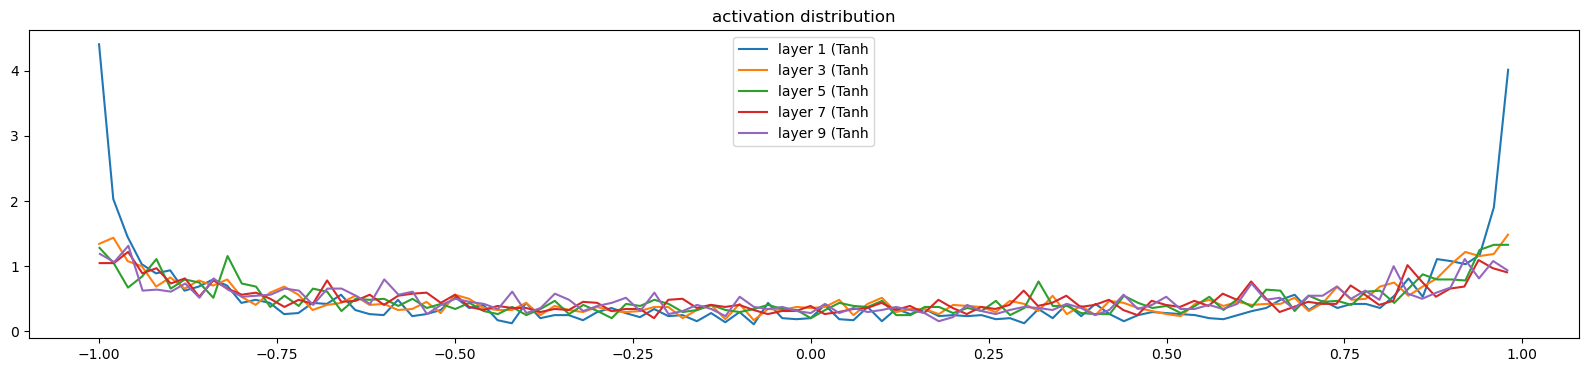

In [61]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

- <b> std become fixed: 0.66

## with gain 1 (no 5/3) for linear:

layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

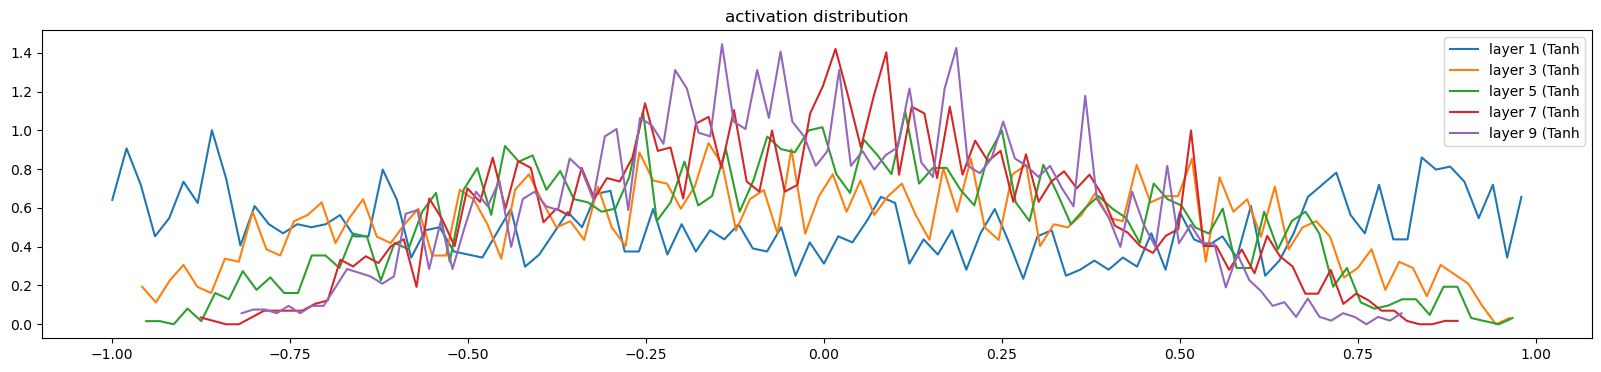

In [64]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

- <b> std become shrinking down </b>
- <b> bcz tanh is making it between 1 and -1 </b>
  

## with gain 3 (no 5/3) for linear:

layer 1 (      Tanh): mean -0.03, std 0.85, saturated: 47.66%
layer 3 (      Tanh): mean +0.00, std 0.84, saturated: 40.47%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 42.38%
layer 7 (      Tanh): mean -0.01, std 0.84, saturated: 42.00%
layer 9 (      Tanh): mean -0.03, std 0.84, saturated: 42.41%


Text(0.5, 1.0, 'activation distribution')

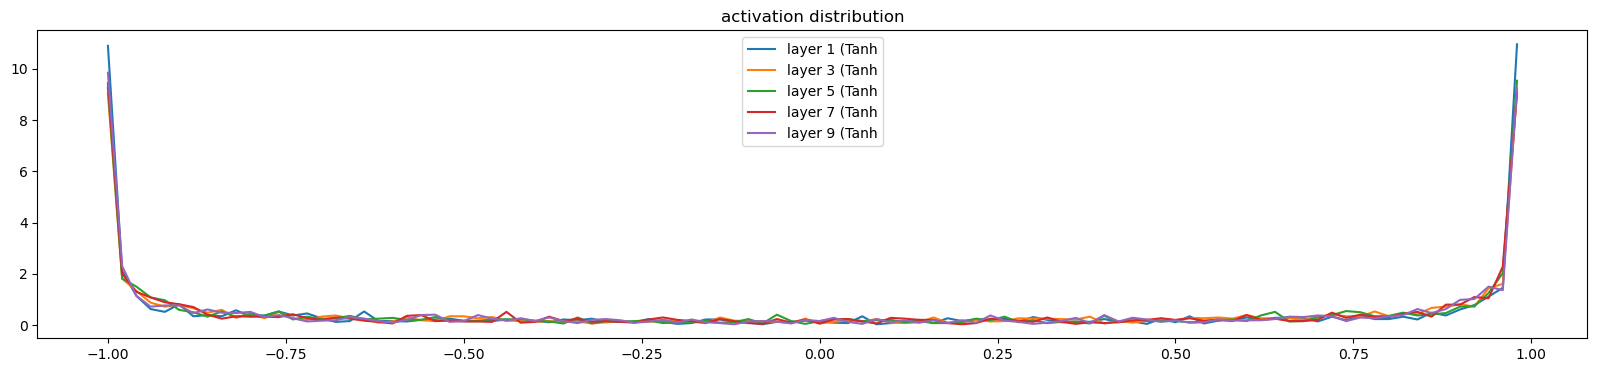

In [67]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

- <b> very saturated </b>

## with gain 0.5 (no 5/3) for linear:

layer 1 (      Tanh): mean -0.01, std 0.41, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.20, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.10, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

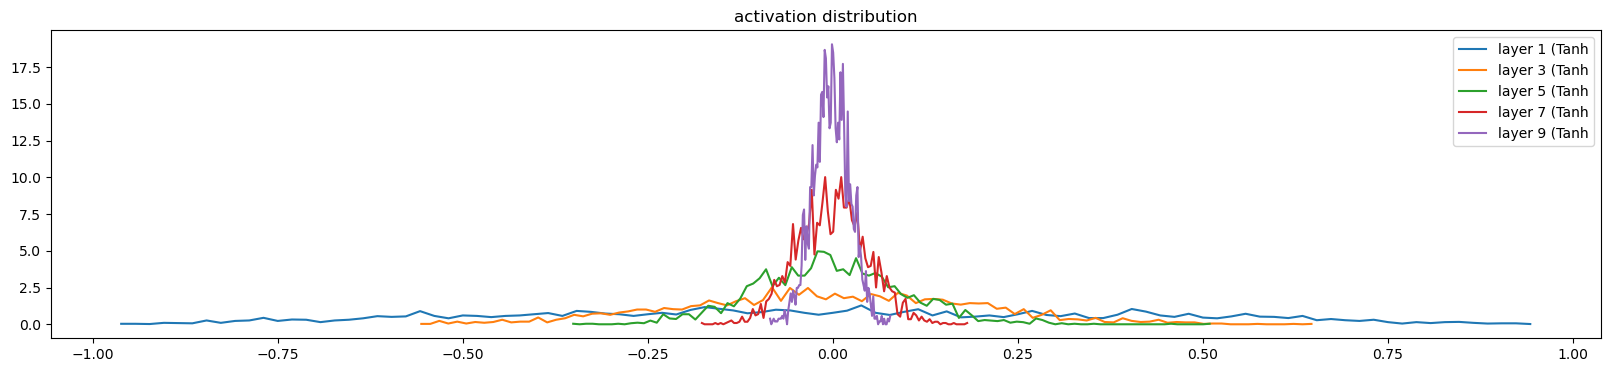

In [75]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# Vizualize layers gradients histograms

## with gain 5/3

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

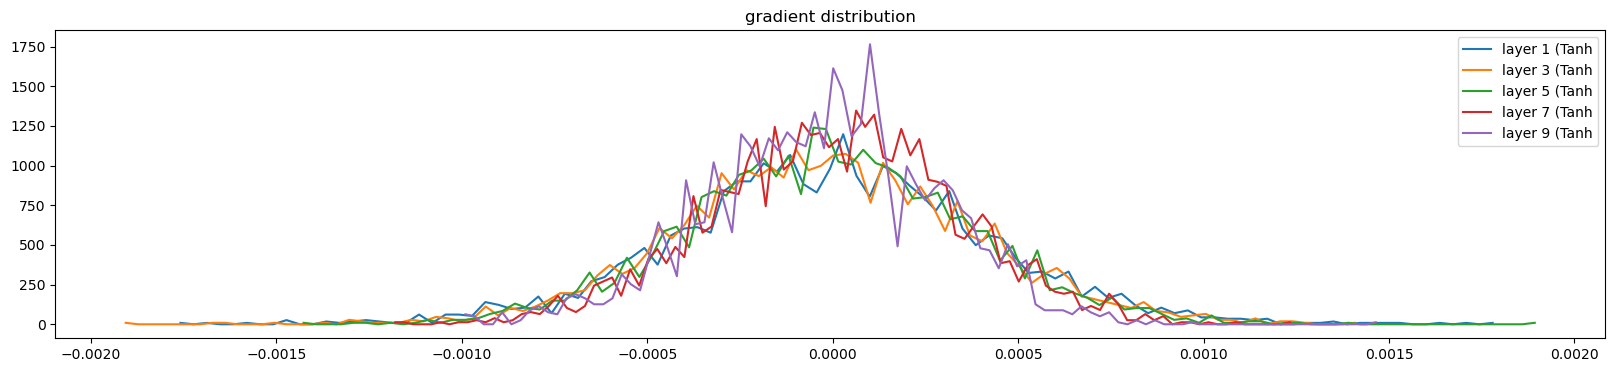

In [71]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## with gain small 0.5

layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561152e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


Text(0.5, 1.0, 'gradient distribution')

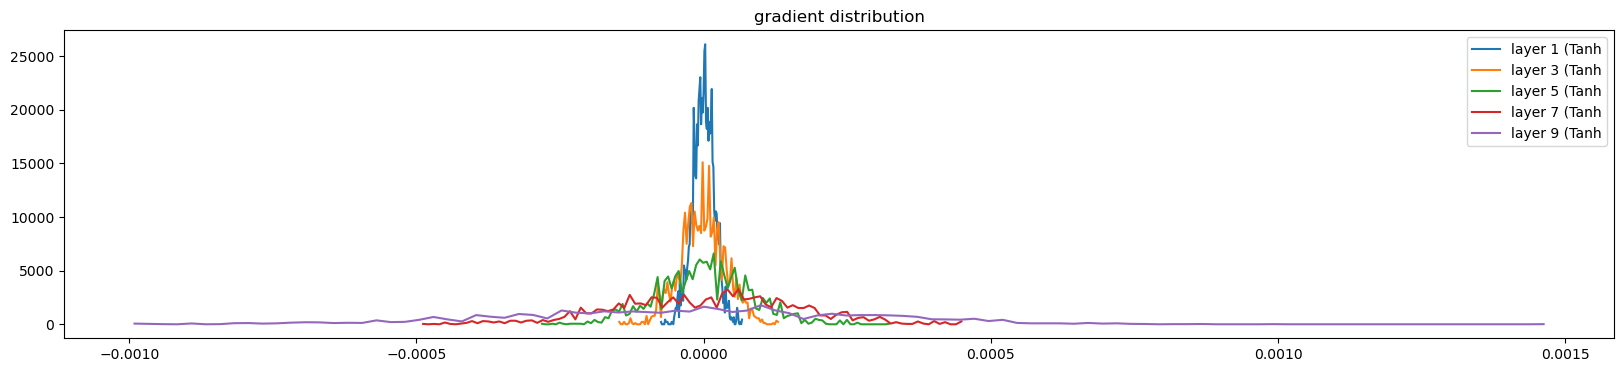

In [74]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## with gain 3

layer 1 (      Tanh): mean -0.000001, std 9.977490e-04
layer 3 (      Tanh): mean +0.000010, std 7.421207e-04
layer 5 (      Tanh): mean +0.000003, std 5.569782e-04
layer 7 (      Tanh): mean +0.000017, std 3.952166e-04
layer 9 (      Tanh): mean -0.000014, std 3.051525e-04


Text(0.5, 1.0, 'gradient distribution')

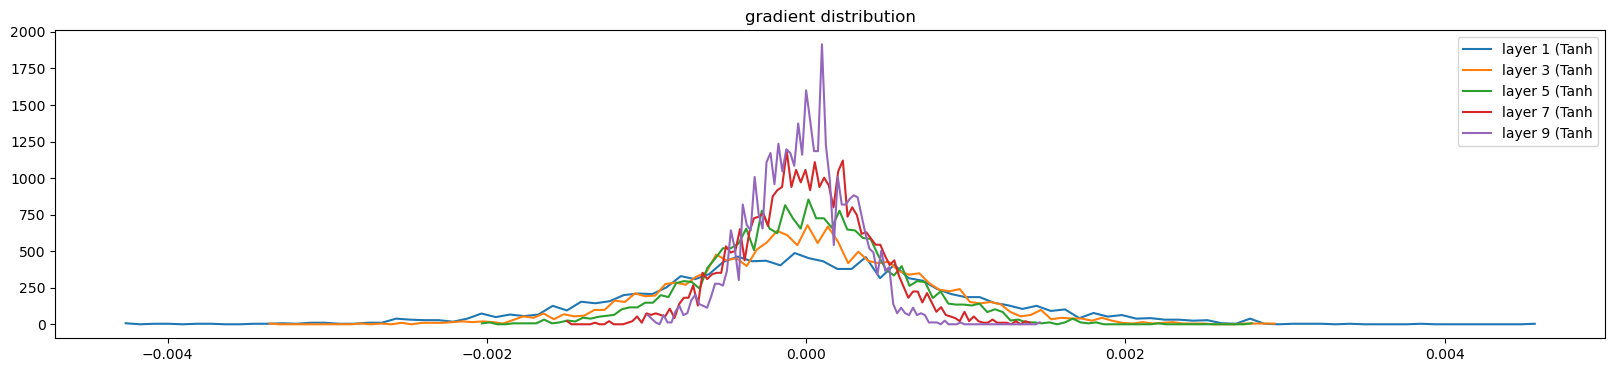

In [68]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

- <b> Also gradients changing</b>

# Vizualize layers activations and gradients histograms with out tanh

In [87]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = xhat * self.gamma + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)


layers = [
    Linear(n_embd * block_size, n_hidden), # Tanh(),
    Linear(n_hidden, n_hidden), # Tanh(),
    Linear(n_hidden, n_hidden), # Tanh(),
    Linear(n_hidden, n_hidden), # Tanh(),
    Linear(n_hidden, n_hidden), # Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].weight *= 0.1
    
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 # 0.5 # 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concat vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain grad
        
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    break # AFTER DEBUG: would take out obviously to run full optimization

46497
      0/ 200000: 3.3019


## activations: gain 5/3

layer 0 (    Linear): mean -0.04, std 1.65, saturated: 55.12%
layer 1 (    Linear): mean -0.04, std 2.72, saturated: 71.78%
layer 2 (    Linear): mean -0.00, std 4.67, saturated: 81.31%
layer 3 (    Linear): mean +0.09, std 7.50, saturated: 91.19%
layer 4 (    Linear): mean -0.72, std 12.78, saturated: 93.69%


Text(0.5, 1.0, 'activation distribution')

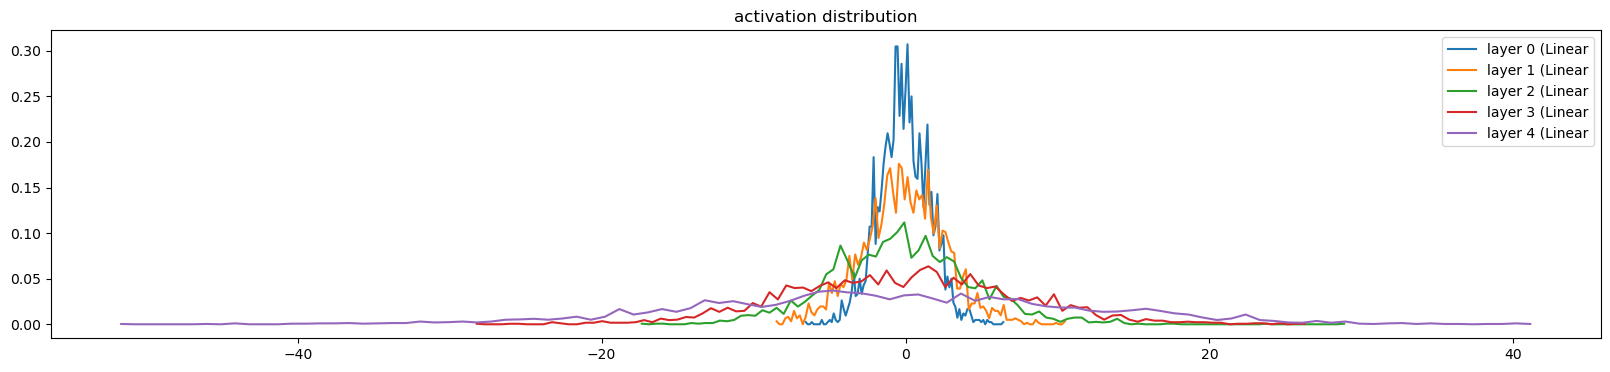

In [82]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

- <b> become diffuse </b>

## gradients: gain 5/3

layer 0 (    Linear): mean +0.000053, std 2.619185e-03
layer 1 (    Linear): mean -0.000006, std 1.583188e-03
layer 2 (    Linear): mean +0.000043, std 9.519162e-04
layer 3 (    Linear): mean +0.000019, std 5.457934e-04
layer 4 (    Linear): mean -0.000013, std 3.161244e-04


Text(0.5, 1.0, 'gradient distribution')

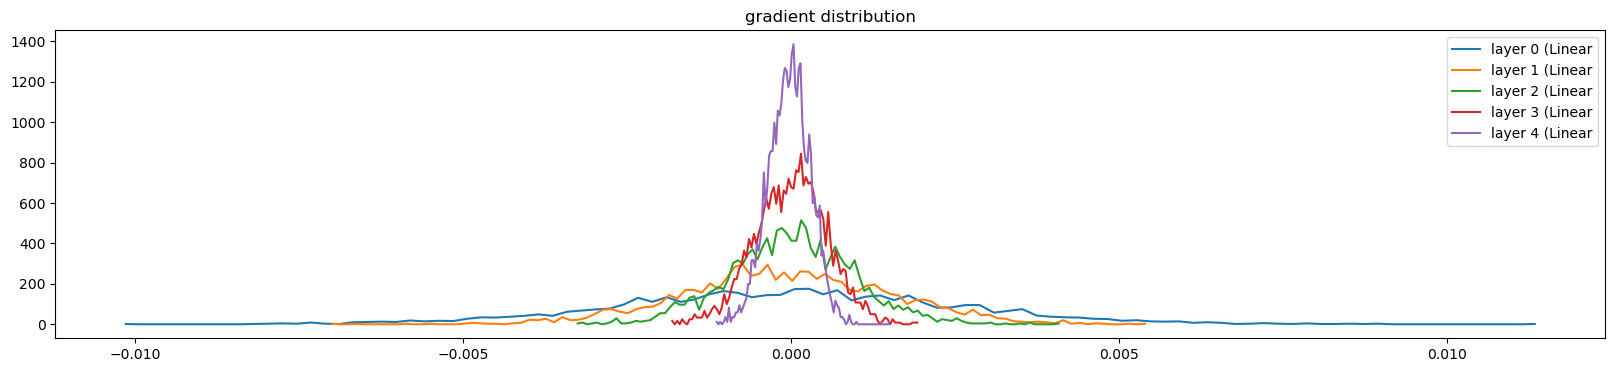

In [83]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

<b> deminish as they go down </b>

## activations: gain 0.5

layer 0 (    Linear): mean -0.01, std 0.49, saturated: 5.06%
layer 1 (    Linear): mean -0.00, std 0.25, saturated: 0.00%
layer 2 (    Linear): mean -0.00, std 0.13, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.06, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.03, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

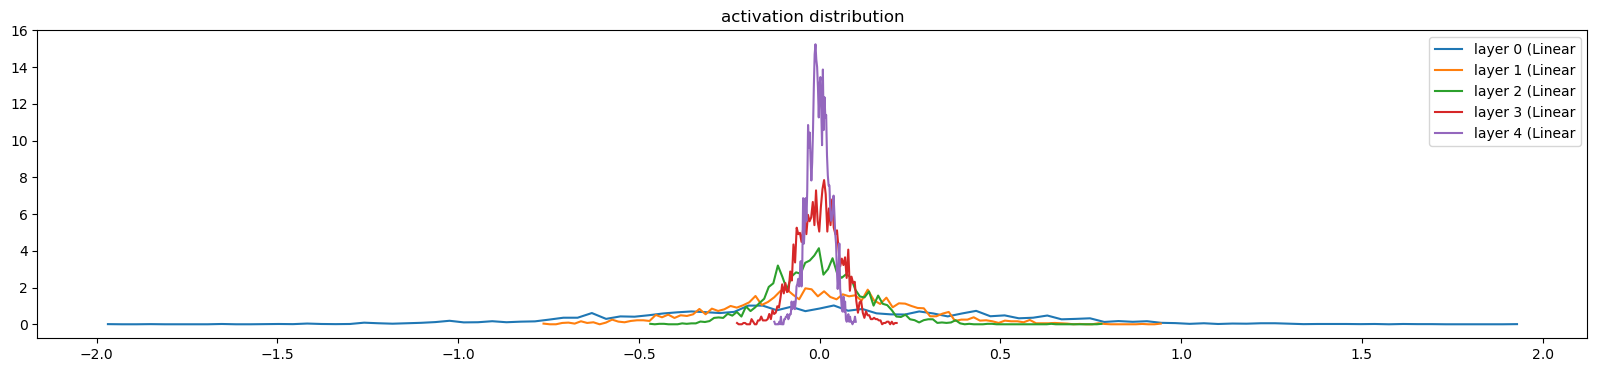

In [85]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## gradients: gain 0.5

layer 0 (    Linear): mean +0.000000, std 1.990759e-05
layer 1 (    Linear): mean -0.000001, std 3.997084e-05
layer 2 (    Linear): mean +0.000004, std 8.058026e-05
layer 3 (    Linear): mean +0.000009, std 1.562154e-04
layer 4 (    Linear): mean -0.000014, std 3.053490e-04


Text(0.5, 1.0, 'gradient distribution')

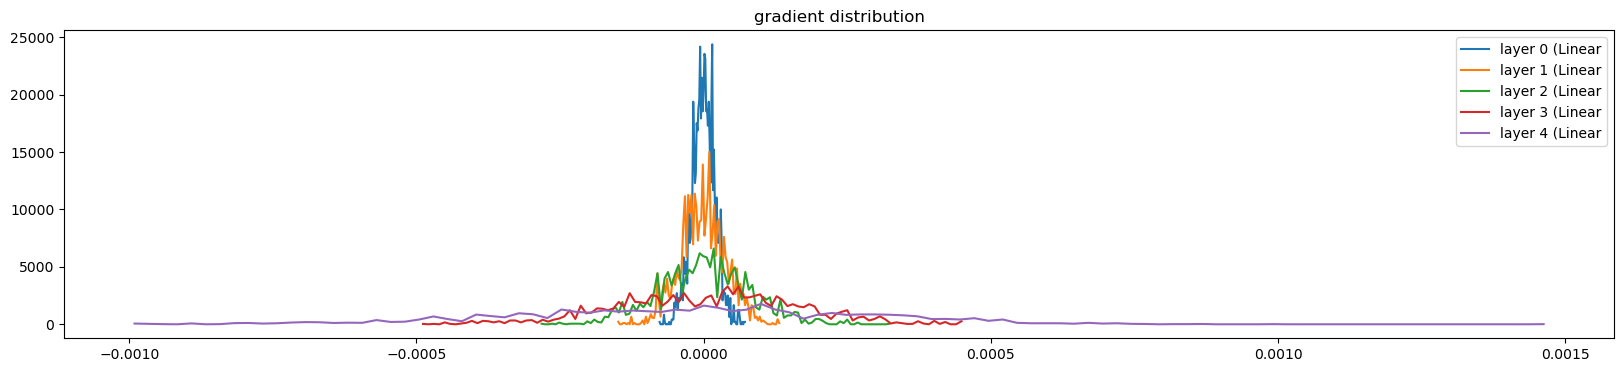

In [86]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## activations: gain 1 (correct)

layer 0 (    Linear): mean -0.02, std 0.99, saturated: 32.16%
layer 1 (    Linear): mean -0.01, std 0.98, saturated: 31.12%
layer 2 (    Linear): mean -0.00, std 1.01, saturated: 31.16%
layer 3 (    Linear): mean +0.01, std 0.97, saturated: 31.66%
layer 4 (    Linear): mean -0.06, std 0.99, saturated: 32.47%


Text(0.5, 1.0, 'activation distribution')

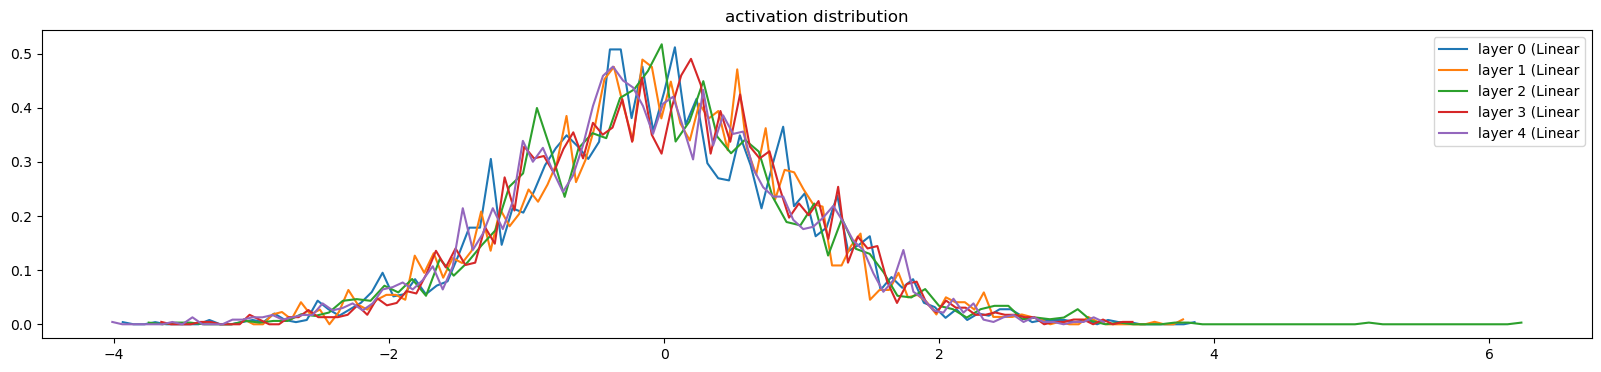

In [88]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## gradients: gain 1 (correct)

layer 0 (    Linear): mean +0.000005, std 3.190493e-04
layer 1 (    Linear): mean -0.000004, std 3.204010e-04
layer 2 (    Linear): mean +0.000015, std 3.229072e-04
layer 3 (    Linear): mean +0.000018, std 3.127774e-04
layer 4 (    Linear): mean -0.000014, std 3.055150e-04


Text(0.5, 1.0, 'gradient distribution')

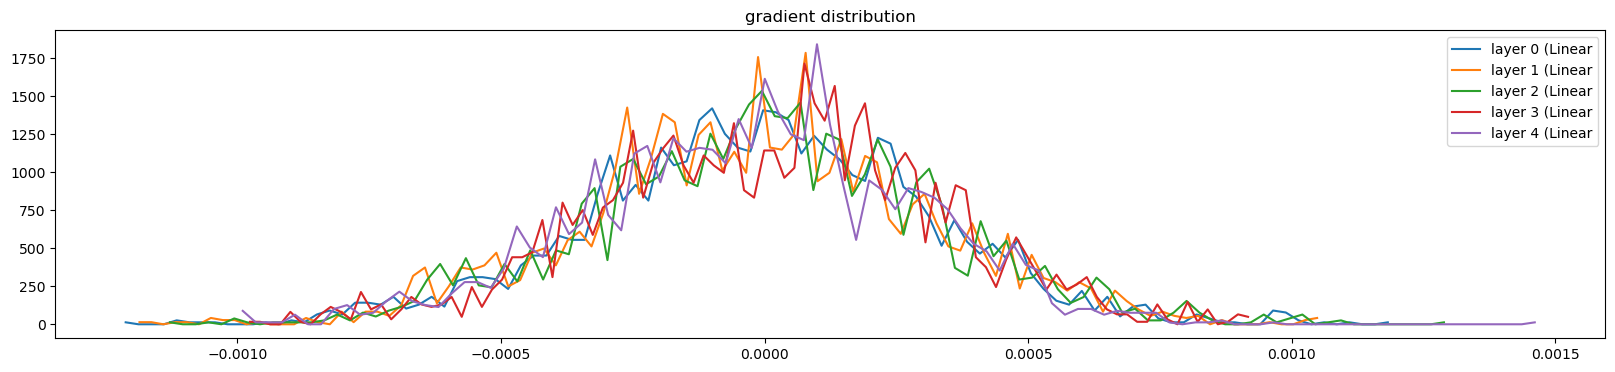

In [89]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# Setting all properly

In [90]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = xhat * self.gamma + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)


layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].weight *= 0.1
    
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concat vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain grad
        
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
#     print('minibatch loss: ', loss.item())

    break # AFTER DEBUG: would take out obviously to run full optimization

46497
      0/ 200000: 3.2962


## activations: gain 5/3 (correct)

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

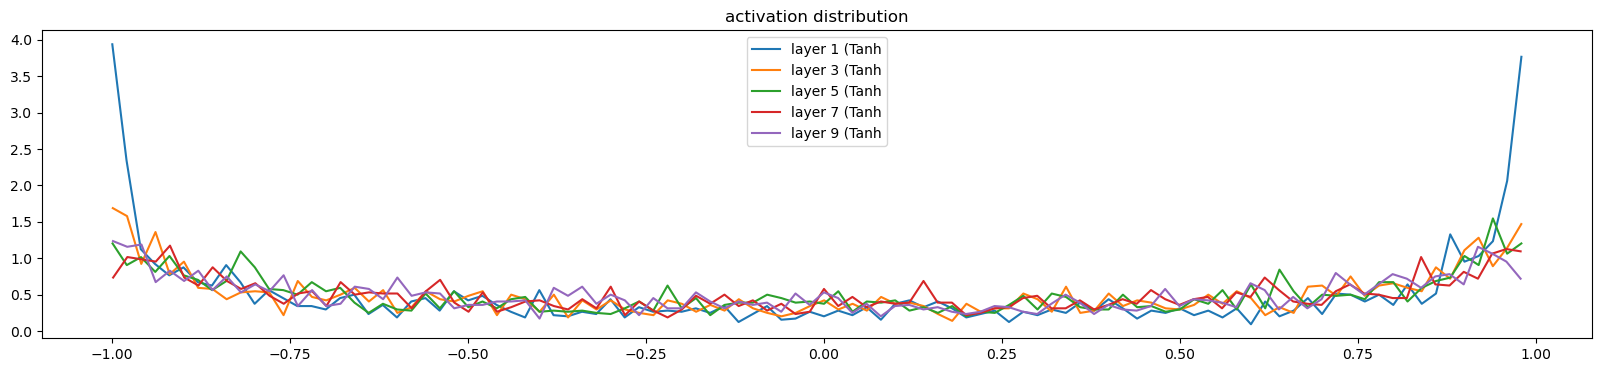

In [91]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## gradients: gain 5/3 (correct)

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

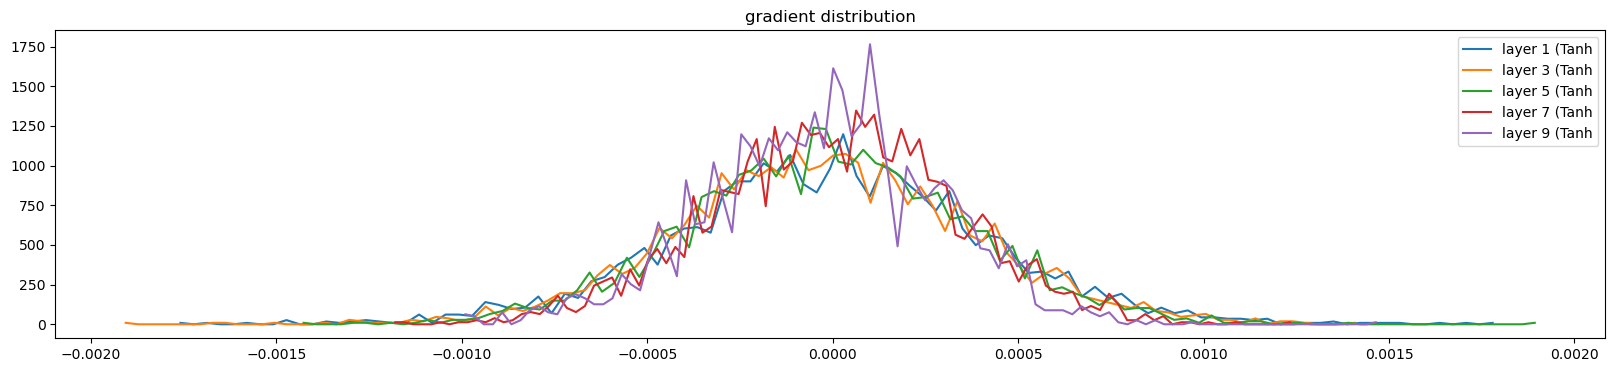

In [92]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601989e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


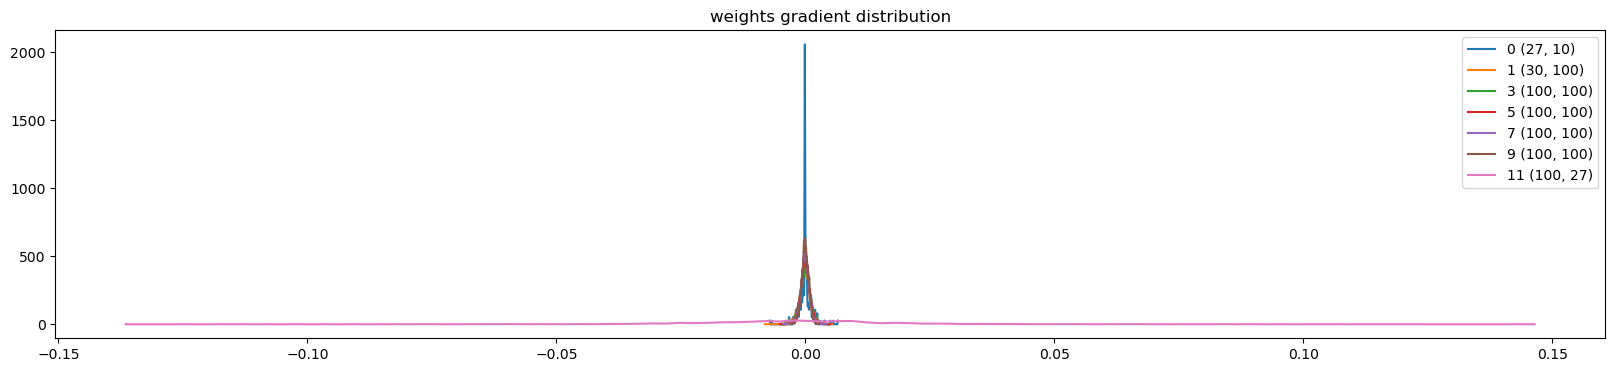

In [93]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

- <b> If we make gradients/data too large -> we are in trouble </b>
- <b> Train last layer 10 times faster, bcz std bigger </b>

# Setting all properly more steps training

In [104]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = xhat * self.gamma + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)


layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].weight *= 0.1
    
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

ud = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concat vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain grad
        
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.001 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    
    # compare out update to our params scales
    # how great update to values
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
#     print('minibatch loss: ', loss.item())
    if i >= 1000:
        break  # AFTER DEBUG: would take out obviously to run full optimization

46497
      0/ 200000: 3.2962


## activations: gain 5/3 (correct)

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

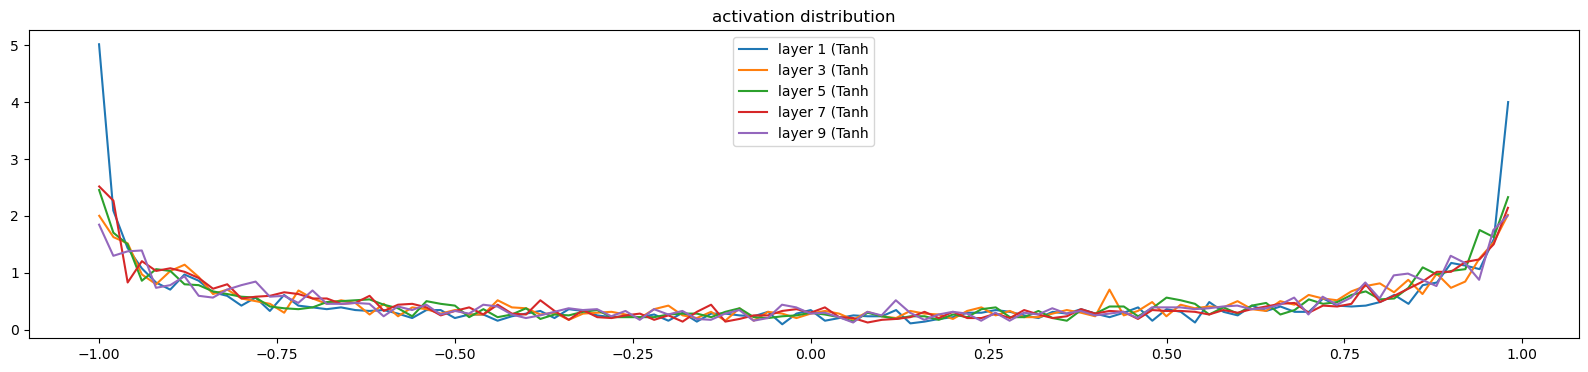

In [100]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## gradients: gain 5/3 (correct)

layer 1 (      Tanh): mean +0.000024, std 3.353993e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715701e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

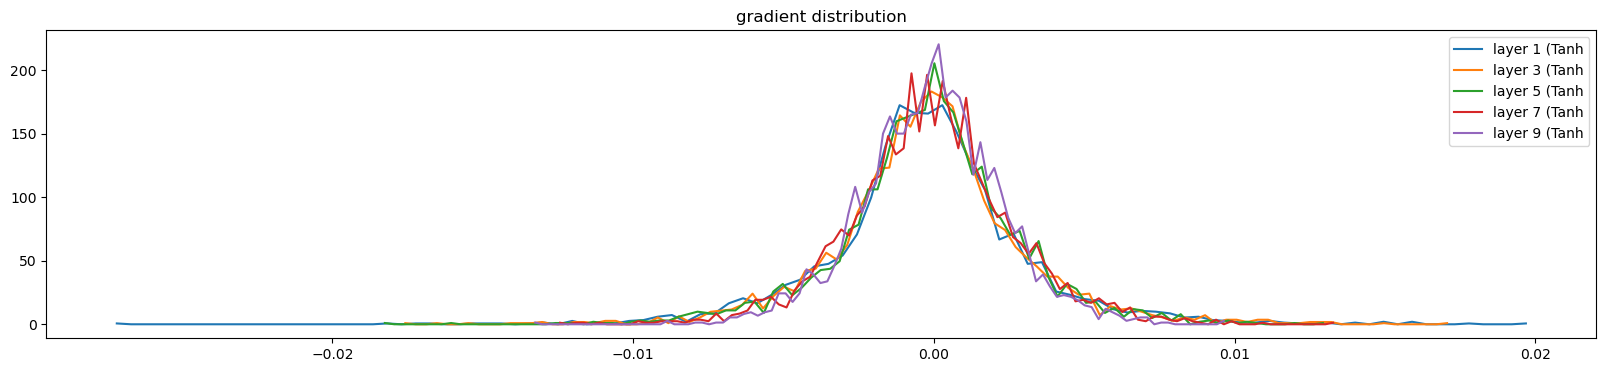

In [101]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189150e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821213e-03 | grad:data ratio 4.653363e-02
weight (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086042e-03 | grad:data ratio 3.605769e-02
weight (100, 100) | mean -0.000077 | std 5.075622e-03 | grad:data ratio 3.015270e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


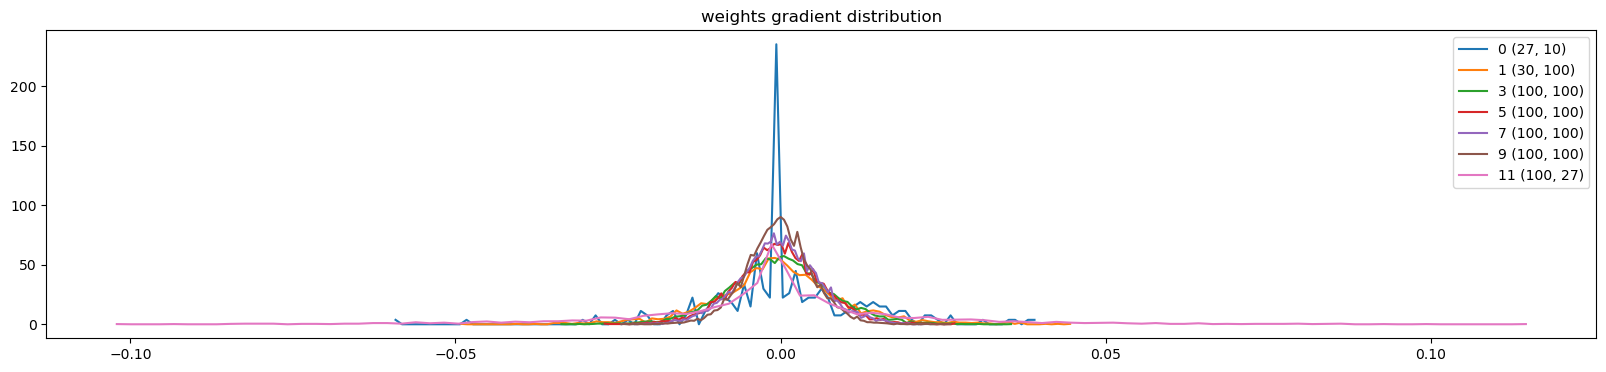

In [102]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

- <b> If we make gradients/data too large -> we are in trouble </b>
- <b> Train last layer 10 times faster, bcz std bigger </b>

## update grad to value in weights tensors

### lr is 0.1

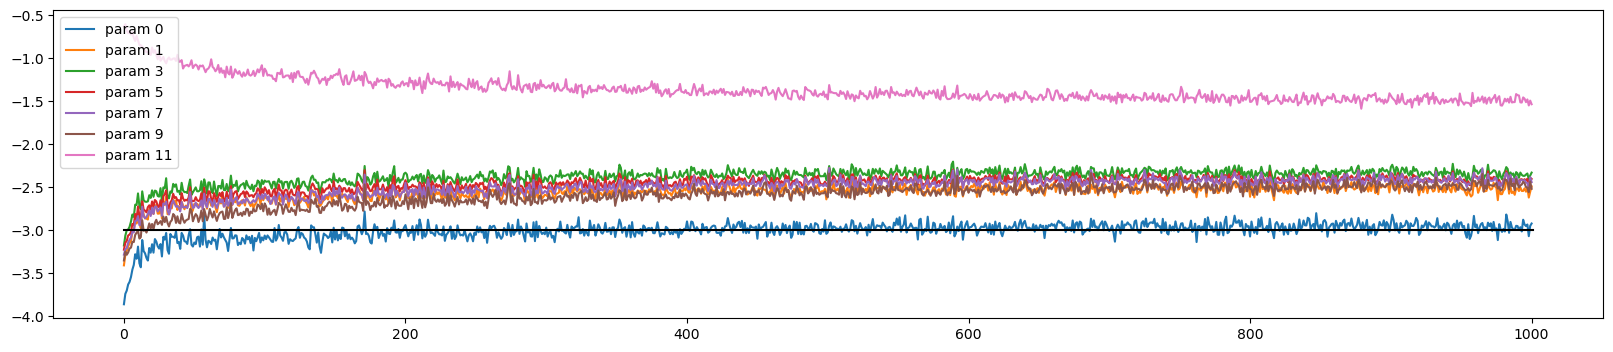

In [103]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

- <b> line - just what is should be </b>
- <b> updates are no more than 1/1000 of weight (bcz log plot) </b>
- <b> if it like -1 (1/10) -> update is realy a lot (very big) </b>
- <b> if it below line -> train not fast </b>

### lr is small: 0.001

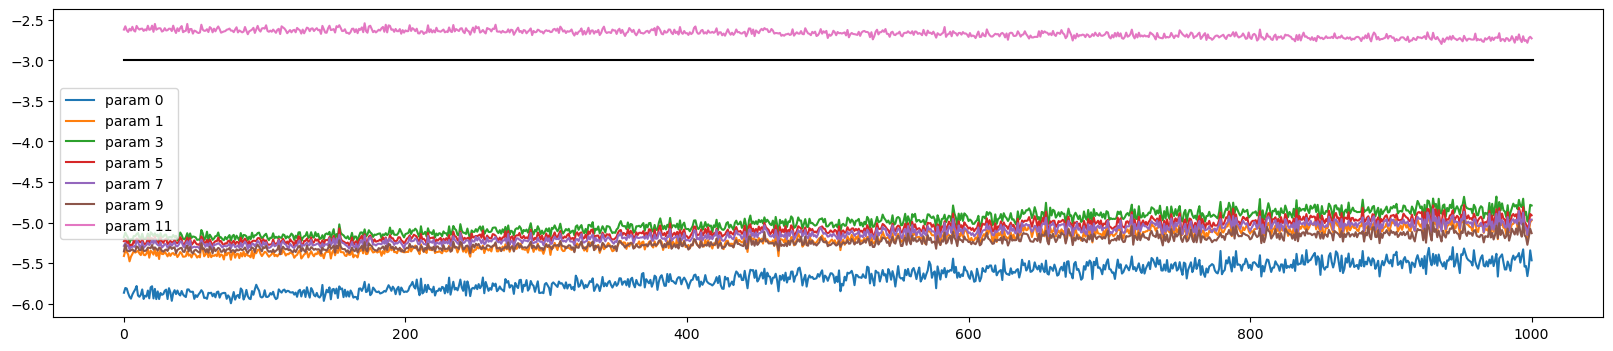

In [105]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

- <b> train is slow: updates like 10000 smaller than values </b>

# Make Layers

In [106]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = xhat * self.gamma + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# Adding batch norm

In [107]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)


layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), # set it before loss on last layer is really good too
]

with torch.no_grad():
    # last layer make less confident
#     layers[-1].weight *= 0.1 # COMMENT BCZ last layer is using batch norm
    layers[-1].gamma  *= 0.1
    
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
loglossi = []

ud = []

for i in range(max_steps):
    
    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concat vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain grad
        
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001 if i > 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    
    # compare out update to our params scales
    # how great update to values
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
#     print('minibatch loss: ', loss.item())
    if i >= 1000:
        break  # AFTER DEBUG: would take out obviously to run full optimization

47551
      0/ 200000: 3.2870


## activations

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

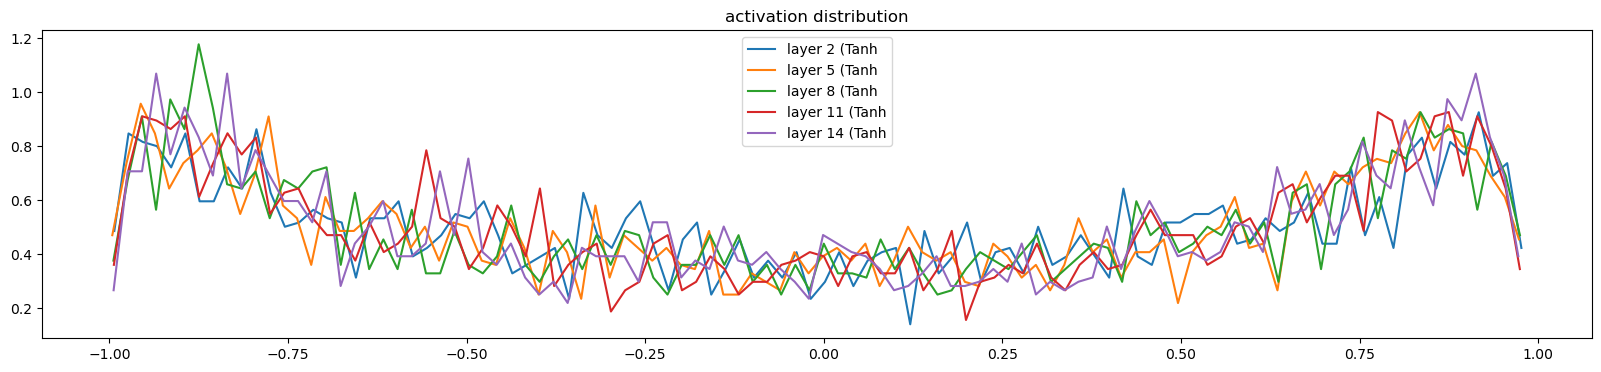

In [108]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## gradients

layer 2 (      Tanh): mean -0.000000, std 3.682954e-03
layer 5 (      Tanh): mean -0.000000, std 3.262609e-03
layer 8 (      Tanh): mean +0.000000, std 2.973730e-03
layer 11 (      Tanh): mean -0.000000, std 2.741110e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

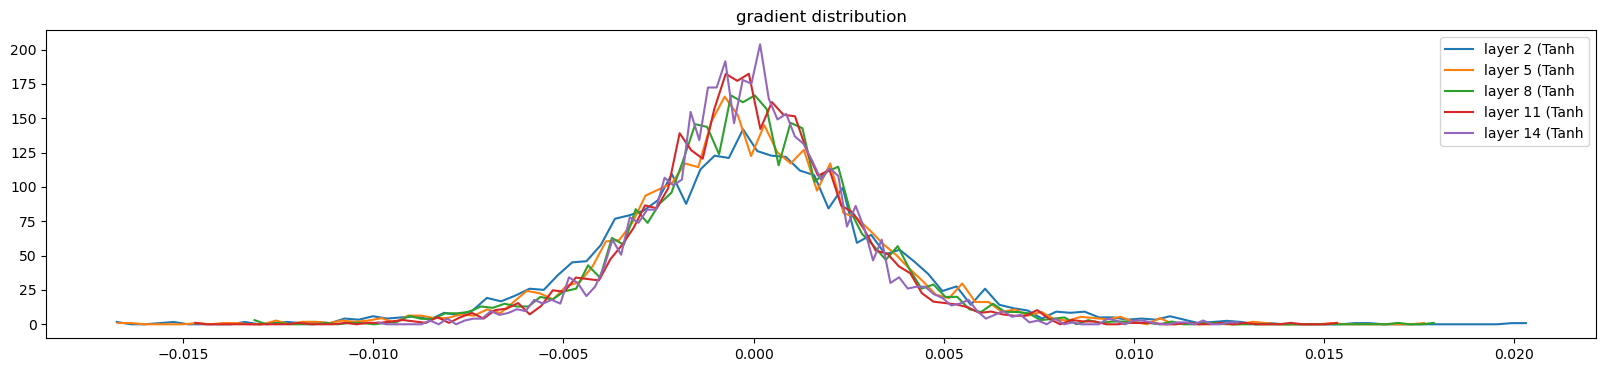

In [109]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019887e-02 | grad:data ratio 1.018847e-02
weight  (30, 100) | mean +0.000092 | std 8.238433e-03 | grad:data ratio 2.635840e-02
weight (100, 100) | mean +0.000031 | std 7.318115e-03 | grad:data ratio 4.377146e-02
weight (100, 100) | mean -0.000019 | std 6.662024e-03 | grad:data ratio 3.949896e-02
weight (100, 100) | mean -0.000019 | std 5.821517e-03 | grad:data ratio 3.468161e-02
weight (100, 100) | mean +0.000053 | std 5.445297e-03 | grad:data ratio 3.243368e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281266e-02


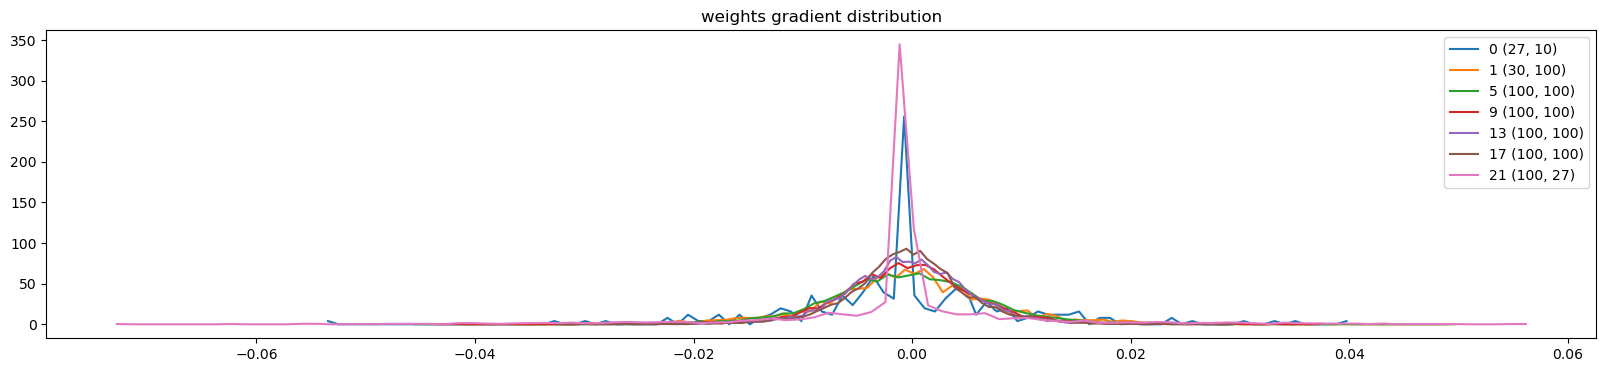

In [110]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

- <b> If we make gradients/data too large -> we are in trouble </b>
- <b> Train last layer 10 times faster, bcz std bigger </b>

## update grad to value in weights tensors

### lr is 0.1

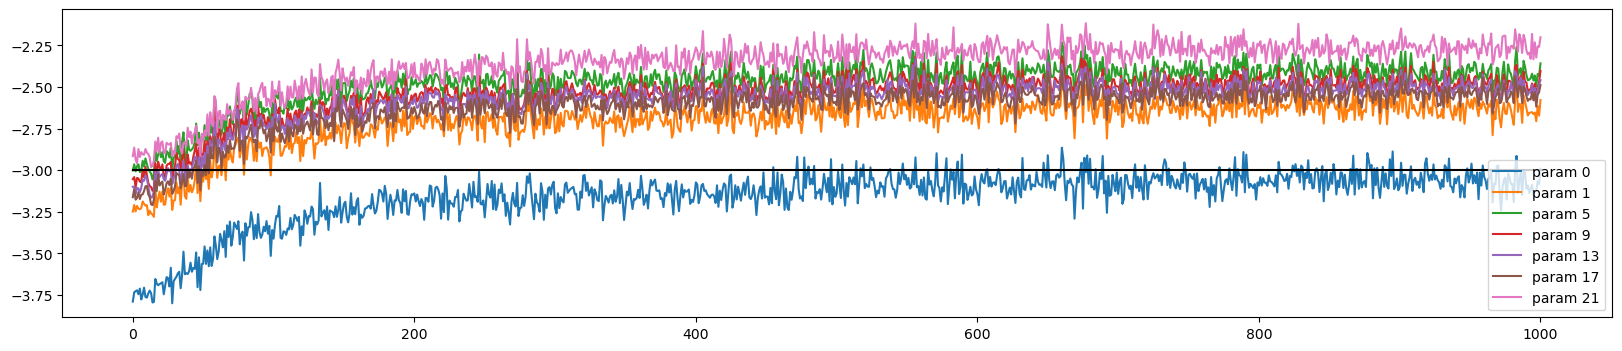

In [111]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

- <b> when introduce batch norm should carry about update scales and increase learning rate </b>